print(train_df.shape)
print(test_df.shape)
print(bids_df.shape)

(2013, 4)
(4700, 3)
(7656334, 8)



FIRST SUBMISSION

Accuracy: 95.36423841059603 %
AUC: 0.5336131934032983

In [1]:
import pandas as pd

bids_df = pd.read_csv('data/bids.csv')
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

bidder_unique = bids_df.groupby("bidder_id").nunique().reset_index()
bidder_unique = bidder_unique.rename(columns  = {"auction" : "auction_nunique" , "merchandise" : "merchandise_nunique" ,
                                              "device" : "device_nunique" ,"time" : "time_nunique" ,
                                               "country" : "country_nunique" ,"ip" : "ip_nunique" ,
                                               "url" : "url_nunique"                                               
                                              })

bidder_unique["country"] = bids_df["country"]
train_set = train_df.merge(bidder_unique, how='left')
test_set = test_df.merge(bidder_unique, how='left')



In [2]:
# train_set = train_df.merge(bids_df, on='bidder_id', how='left')

print(train_set.shape) 
print(test_set.shape) 
print(bidder_unique.shape)



(2013, 12)
(4700, 11)
(6614, 9)


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from catboost import Pool, CatBoostClassifier

def test_model(feature_cols,train_set):

    X = train_set[feature_cols]
    y = train_set['outcome']
    
    ##Random Forest Classifier
    rf_model = RandomForestClassifier(random_state = 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    rf_model = rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    print('Accuracy:', metrics.accuracy_score(y_test, y_pred) * 100, '%')
    print('AUC:', metrics.roc_auc_score(y_test, y_pred)) # performs much worse that the leaderboard :p
    
def test_model2(feature_cols,train_set):

    X = train_set[feature_cols]
    y = train_set['outcome']
    
    ##Random Forest Classifier
    rf_model = CatBoostClassifier(iterations = 10000,random_state = 0)
  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    rf_model = rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    print('Accuracy:', metrics.accuracy_score(y_test, y_pred) * 100, '%')
    print('AUC:', metrics.roc_auc_score(y_test, y_pred)) # performs much worse that the leaderboard :p
    
def concad(train_set,column):
    print("concad shape part1", train_set.shape)
    
    train_set2 = pd.get_dummies(train_set[column])
    train_set3 = pd.concat([train_set, train_set2], axis=1)
    
    print("concad shape part2", train_set.shape)
    
    train_set3 = train_set3.drop(columns = [column]) 
    return train_set3

def transform(train_set):
    train_set = concad(train_set,"country")
    
#     train_set = train_set.merge(bidder_unique, on='bidder_id', how='left')
    
    print("train mode", train_set["device_nunique"].mode())
    
#     train_set = train_set.drop(columns = ["merchandise", "time" , "ip" , "url" , "payment_account" , "address" , "payment_account" , "device", "auction" , "merchandise_nunique"])
    train_set = train_set.drop(columns = ["address" , "payment_account"])
    train_set = train_set.fillna(train_set.mode())
    train_set["device_nunique"] = train_set["device_nunique"].fillna(train_set["device_nunique"].mode()[0])
    train_set["time_nunique"] = train_set["time_nunique"].fillna(train_set["time_nunique"].mode()[0])
    train_set["country_nunique"] = train_set["country_nunique"].fillna(train_set["country_nunique"].mode()[0])
    train_set["ip_nunique"] = train_set["ip_nunique"].fillna(train_set["ip_nunique"].mode()[0])
    train_set["url_nunique"] = train_set["url_nunique"].fillna(train_set["url_nunique"].mode()[0])
    train_set["auction_nunique"] = train_set["auction_nunique"].fillna(train_set["auction_nunique"].mode()[0])
    train_set["merchandise_nunique"] = train_set["merchandise_nunique"].fillna(train_set["merchandise_nunique"].mode()[0])
    return train_set

def transform2(train_set):
        
    train_set = train_set.drop(columns = ["address" , "payment_account","country"])
    train_set = train_set.fillna(train_set.mode())
    train_set["device_nunique"] = train_set["device_nunique"].fillna(train_set["device_nunique"].mode()[0])
    train_set["time_nunique"] = train_set["time_nunique"].fillna(train_set["time_nunique"].mode()[0])
    train_set["country_nunique"] = train_set["country_nunique"].fillna(train_set["country_nunique"].mode()[0])
    train_set["ip_nunique"] = train_set["ip_nunique"].fillna(train_set["ip_nunique"].mode()[0])
    train_set["url_nunique"] = train_set["url_nunique"].fillna(train_set["url_nunique"].mode()[0])
    train_set["auction_nunique"] = train_set["auction_nunique"].fillna(train_set["auction_nunique"].mode()[0])
    train_set["merchandise_nunique"] = train_set["merchandise_nunique"].fillna(train_set["merchandise_nunique"].mode()[0])
    return train_set

def output(feature_cols,test_set,train_set):
    X = train_set[feature_cols]
    y = train_set['outcome']

    
    final_rf_model = RandomForestClassifier(random_state = 0)
    final_rf_model = final_rf_model.fit(X, y)
#     feature_cols = list(test_set.columns)
    X_kaggle = test_set[feature_cols]
    probabilities = final_rf_model.predict_proba(X_kaggle)
    
    kaggle_preds = probabilities[:,1]  # extract values from the rightmost column
    output_dataframe = pd.DataFrame({'Id': test_set['bidder_id'],'Predicted': kaggle_preds})
    output_dataframe.drop_duplicates()
    output_dataframe.to_csv('my_predictions.csv', index=False)  
    
    
def output2(feature_cols,test_set,train_set):
    X = train_set[feature_cols]
    y = train_set['outcome']

    
    final_rf_model = CatBoostClassifier(iterations = 10000)
    final_rf_model = final_rf_model.fit(X, y)
#     feature_cols = list(test_set.columns)
    X_kaggle = test_set[feature_cols]
    probabilities = final_rf_model.predict_proba(X_kaggle)
    
    kaggle_preds = probabilities[:,1]  # extract values from the rightmost column
    output_dataframe = pd.DataFrame({'Id': test_set['bidder_id'],'Predicted': kaggle_preds})
    output_dataframe.drop_duplicates()
    output_dataframe.to_csv('my_predictions.csv', index=False) 

In [29]:
#TEST 2
#no one hot 
train_set2 = transform(train_set)


feature_cols2 = list(train_set2.columns)
feature_cols2.remove("outcome")
feature_cols2.remove("bidder_id")

test_model2(feature_cols2,train_set2)

concad shape part1 (2013, 12)
concad shape part2 (2013, 12)
train mode 0    1.0
dtype: float64
Learning rate set to 0.001444
0:	learn: 0.6905513	total: 2.36ms	remaining: 23.6s
1:	learn: 0.6878881	total: 4.34ms	remaining: 21.7s
2:	learn: 0.6857482	total: 6.28ms	remaining: 20.9s
3:	learn: 0.6835709	total: 8.2ms	remaining: 20.5s
4:	learn: 0.6813321	total: 10.1ms	remaining: 20.2s
5:	learn: 0.6792236	total: 11.9ms	remaining: 19.8s
6:	learn: 0.6765633	total: 13.7ms	remaining: 19.5s
7:	learn: 0.6744570	total: 15.6ms	remaining: 19.4s
8:	learn: 0.6723934	total: 17.4ms	remaining: 19.3s
9:	learn: 0.6702524	total: 19.2ms	remaining: 19.2s
10:	learn: 0.6676245	total: 21ms	remaining: 19s
11:	learn: 0.6651355	total: 22.7ms	remaining: 18.9s
12:	learn: 0.6631692	total: 24.6ms	remaining: 18.9s
13:	learn: 0.6606936	total: 26.4ms	remaining: 18.8s
14:	learn: 0.6584350	total: 28.2ms	remaining: 18.8s
15:	learn: 0.6563490	total: 30ms	remaining: 18.7s
16:	learn: 0.6540747	total: 31.8ms	remaining: 18.7s
17:	lear

236:	learn: 0.3385465	total: 437ms	remaining: 18s
237:	learn: 0.3378523	total: 439ms	remaining: 18s
238:	learn: 0.3368861	total: 441ms	remaining: 18s
239:	learn: 0.3360014	total: 442ms	remaining: 18s
240:	learn: 0.3352597	total: 444ms	remaining: 18s
241:	learn: 0.3346490	total: 447ms	remaining: 18s
242:	learn: 0.3338290	total: 449ms	remaining: 18s
243:	learn: 0.3328855	total: 451ms	remaining: 18s
244:	learn: 0.3322736	total: 453ms	remaining: 18s
245:	learn: 0.3313486	total: 455ms	remaining: 18.1s
246:	learn: 0.3306255	total: 457ms	remaining: 18.1s
247:	learn: 0.3297753	total: 459ms	remaining: 18.1s
248:	learn: 0.3288930	total: 461ms	remaining: 18.1s
249:	learn: 0.3279688	total: 463ms	remaining: 18.1s
250:	learn: 0.3271534	total: 465ms	remaining: 18.1s
251:	learn: 0.3263508	total: 467ms	remaining: 18.1s
252:	learn: 0.3255874	total: 469ms	remaining: 18.1s
253:	learn: 0.3247238	total: 471ms	remaining: 18.1s
254:	learn: 0.3239278	total: 473ms	remaining: 18.1s
255:	learn: 0.3230606	total: 4

396:	learn: 0.2443693	total: 766ms	remaining: 18.5s
397:	learn: 0.2438867	total: 768ms	remaining: 18.5s
398:	learn: 0.2436082	total: 770ms	remaining: 18.5s
399:	learn: 0.2432760	total: 772ms	remaining: 18.5s
400:	learn: 0.2428042	total: 774ms	remaining: 18.5s
401:	learn: 0.2423742	total: 776ms	remaining: 18.5s
402:	learn: 0.2420391	total: 778ms	remaining: 18.5s
403:	learn: 0.2417377	total: 780ms	remaining: 18.5s
404:	learn: 0.2413775	total: 782ms	remaining: 18.5s
405:	learn: 0.2409330	total: 784ms	remaining: 18.5s
406:	learn: 0.2406343	total: 786ms	remaining: 18.5s
407:	learn: 0.2402769	total: 788ms	remaining: 18.5s
408:	learn: 0.2399726	total: 790ms	remaining: 18.5s
409:	learn: 0.2394636	total: 792ms	remaining: 18.5s
410:	learn: 0.2390027	total: 793ms	remaining: 18.5s
411:	learn: 0.2385996	total: 795ms	remaining: 18.5s
412:	learn: 0.2380949	total: 797ms	remaining: 18.5s
413:	learn: 0.2376463	total: 799ms	remaining: 18.5s
414:	learn: 0.2372415	total: 801ms	remaining: 18.5s
415:	learn: 

577:	learn: 0.1911315	total: 1.1s	remaining: 18s
578:	learn: 0.1909296	total: 1.11s	remaining: 18s
579:	learn: 0.1907939	total: 1.11s	remaining: 18s
580:	learn: 0.1905648	total: 1.11s	remaining: 18s
581:	learn: 0.1904449	total: 1.11s	remaining: 18s
582:	learn: 0.1902902	total: 1.11s	remaining: 18s
583:	learn: 0.1900496	total: 1.12s	remaining: 18s
584:	learn: 0.1898098	total: 1.12s	remaining: 18s
585:	learn: 0.1896062	total: 1.12s	remaining: 18s
586:	learn: 0.1893971	total: 1.12s	remaining: 18s
587:	learn: 0.1892631	total: 1.13s	remaining: 18s
588:	learn: 0.1890416	total: 1.13s	remaining: 18s
589:	learn: 0.1888379	total: 1.13s	remaining: 18s
590:	learn: 0.1886346	total: 1.13s	remaining: 18s
591:	learn: 0.1884096	total: 1.13s	remaining: 18s
592:	learn: 0.1881766	total: 1.13s	remaining: 18s
593:	learn: 0.1880257	total: 1.14s	remaining: 18s
594:	learn: 0.1878532	total: 1.14s	remaining: 18s
595:	learn: 0.1876277	total: 1.14s	remaining: 18s
596:	learn: 0.1874352	total: 1.14s	remaining: 18s
5

759:	learn: 0.1635385	total: 1.44s	remaining: 17.5s
760:	learn: 0.1633796	total: 1.44s	remaining: 17.5s
761:	learn: 0.1632679	total: 1.45s	remaining: 17.5s
762:	learn: 0.1631309	total: 1.45s	remaining: 17.5s
763:	learn: 0.1630694	total: 1.45s	remaining: 17.5s
764:	learn: 0.1629336	total: 1.45s	remaining: 17.5s
765:	learn: 0.1628108	total: 1.45s	remaining: 17.5s
766:	learn: 0.1626619	total: 1.46s	remaining: 17.5s
767:	learn: 0.1625602	total: 1.46s	remaining: 17.5s
768:	learn: 0.1624205	total: 1.46s	remaining: 17.5s
769:	learn: 0.1622744	total: 1.46s	remaining: 17.5s
770:	learn: 0.1621300	total: 1.46s	remaining: 17.5s
771:	learn: 0.1620321	total: 1.47s	remaining: 17.5s
772:	learn: 0.1619129	total: 1.47s	remaining: 17.5s
773:	learn: 0.1617751	total: 1.47s	remaining: 17.5s
774:	learn: 0.1617013	total: 1.47s	remaining: 17.5s
775:	learn: 0.1615846	total: 1.47s	remaining: 17.5s
776:	learn: 0.1614326	total: 1.48s	remaining: 17.5s
777:	learn: 0.1613644	total: 1.48s	remaining: 17.5s
778:	learn: 

938:	learn: 0.1476430	total: 1.77s	remaining: 17.1s
939:	learn: 0.1475851	total: 1.77s	remaining: 17.1s
940:	learn: 0.1474997	total: 1.78s	remaining: 17.1s
941:	learn: 0.1474203	total: 1.78s	remaining: 17.1s
942:	learn: 0.1473567	total: 1.78s	remaining: 17.1s
943:	learn: 0.1472583	total: 1.78s	remaining: 17.1s
944:	learn: 0.1472099	total: 1.78s	remaining: 17.1s
945:	learn: 0.1471680	total: 1.79s	remaining: 17.1s
946:	learn: 0.1470868	total: 1.79s	remaining: 17.1s
947:	learn: 0.1469757	total: 1.79s	remaining: 17.1s
948:	learn: 0.1469094	total: 1.79s	remaining: 17.1s
949:	learn: 0.1468601	total: 1.79s	remaining: 17.1s
950:	learn: 0.1467732	total: 1.8s	remaining: 17.1s
951:	learn: 0.1467022	total: 1.8s	remaining: 17.1s
952:	learn: 0.1466188	total: 1.8s	remaining: 17.1s
953:	learn: 0.1465245	total: 1.8s	remaining: 17.1s
954:	learn: 0.1464527	total: 1.8s	remaining: 17.1s
955:	learn: 0.1464104	total: 1.8s	remaining: 17.1s
956:	learn: 0.1463174	total: 1.81s	remaining: 17.1s
957:	learn: 0.1462

1106:	learn: 0.1375196	total: 2.09s	remaining: 16.8s
1107:	learn: 0.1374467	total: 2.09s	remaining: 16.8s
1108:	learn: 0.1373878	total: 2.1s	remaining: 16.8s
1109:	learn: 0.1373481	total: 2.1s	remaining: 16.8s
1110:	learn: 0.1373090	total: 2.1s	remaining: 16.8s
1111:	learn: 0.1372547	total: 2.1s	remaining: 16.8s
1112:	learn: 0.1372245	total: 2.1s	remaining: 16.8s
1113:	learn: 0.1371555	total: 2.11s	remaining: 16.8s
1114:	learn: 0.1371334	total: 2.11s	remaining: 16.8s
1115:	learn: 0.1371056	total: 2.11s	remaining: 16.8s
1116:	learn: 0.1370551	total: 2.11s	remaining: 16.8s
1117:	learn: 0.1370197	total: 2.11s	remaining: 16.8s
1118:	learn: 0.1369816	total: 2.12s	remaining: 16.8s
1119:	learn: 0.1369419	total: 2.12s	remaining: 16.8s
1120:	learn: 0.1368837	total: 2.12s	remaining: 16.8s
1121:	learn: 0.1368367	total: 2.12s	remaining: 16.8s
1122:	learn: 0.1368126	total: 2.12s	remaining: 16.8s
1123:	learn: 0.1367727	total: 2.13s	remaining: 16.8s
1124:	learn: 0.1367295	total: 2.13s	remaining: 16.8

1288:	learn: 0.1293991	total: 2.43s	remaining: 16.4s
1289:	learn: 0.1293570	total: 2.43s	remaining: 16.4s
1290:	learn: 0.1293060	total: 2.43s	remaining: 16.4s
1291:	learn: 0.1292763	total: 2.44s	remaining: 16.4s
1292:	learn: 0.1292534	total: 2.44s	remaining: 16.4s
1293:	learn: 0.1292005	total: 2.44s	remaining: 16.4s
1294:	learn: 0.1291677	total: 2.44s	remaining: 16.4s
1295:	learn: 0.1291323	total: 2.44s	remaining: 16.4s
1296:	learn: 0.1291028	total: 2.45s	remaining: 16.4s
1297:	learn: 0.1290669	total: 2.45s	remaining: 16.4s
1298:	learn: 0.1290176	total: 2.45s	remaining: 16.4s
1299:	learn: 0.1289929	total: 2.45s	remaining: 16.4s
1300:	learn: 0.1289662	total: 2.45s	remaining: 16.4s
1301:	learn: 0.1289200	total: 2.46s	remaining: 16.4s
1302:	learn: 0.1288982	total: 2.46s	remaining: 16.4s
1303:	learn: 0.1288611	total: 2.46s	remaining: 16.4s
1304:	learn: 0.1288392	total: 2.46s	remaining: 16.4s
1305:	learn: 0.1288041	total: 2.46s	remaining: 16.4s
1306:	learn: 0.1287549	total: 2.46s	remaining:

1472:	learn: 0.1232691	total: 2.77s	remaining: 16s
1473:	learn: 0.1232338	total: 2.77s	remaining: 16s
1474:	learn: 0.1232100	total: 2.77s	remaining: 16s
1475:	learn: 0.1231648	total: 2.77s	remaining: 16s
1476:	learn: 0.1231265	total: 2.78s	remaining: 16s
1477:	learn: 0.1230810	total: 2.78s	remaining: 16s
1478:	learn: 0.1230708	total: 2.78s	remaining: 16s
1479:	learn: 0.1230303	total: 2.78s	remaining: 16s
1480:	learn: 0.1229825	total: 2.78s	remaining: 16s
1481:	learn: 0.1229645	total: 2.79s	remaining: 16s
1482:	learn: 0.1229073	total: 2.79s	remaining: 16s
1483:	learn: 0.1228709	total: 2.79s	remaining: 16s
1484:	learn: 0.1228353	total: 2.79s	remaining: 16s
1485:	learn: 0.1227847	total: 2.79s	remaining: 16s
1486:	learn: 0.1227637	total: 2.8s	remaining: 16s
1487:	learn: 0.1227304	total: 2.8s	remaining: 16s
1488:	learn: 0.1227039	total: 2.8s	remaining: 16s
1489:	learn: 0.1226862	total: 2.8s	remaining: 16s
1490:	learn: 0.1226534	total: 2.8s	remaining: 16s
1491:	learn: 0.1226011	total: 2.81s	

1637:	learn: 0.1186934	total: 3.08s	remaining: 15.7s
1638:	learn: 0.1186577	total: 3.08s	remaining: 15.7s
1639:	learn: 0.1186426	total: 3.08s	remaining: 15.7s
1640:	learn: 0.1186264	total: 3.09s	remaining: 15.7s
1641:	learn: 0.1185843	total: 3.09s	remaining: 15.7s
1642:	learn: 0.1185510	total: 3.09s	remaining: 15.7s
1643:	learn: 0.1185190	total: 3.09s	remaining: 15.7s
1644:	learn: 0.1184827	total: 3.09s	remaining: 15.7s
1645:	learn: 0.1184425	total: 3.1s	remaining: 15.7s
1646:	learn: 0.1184317	total: 3.1s	remaining: 15.7s
1647:	learn: 0.1184091	total: 3.1s	remaining: 15.7s
1648:	learn: 0.1183894	total: 3.1s	remaining: 15.7s
1649:	learn: 0.1183631	total: 3.1s	remaining: 15.7s
1650:	learn: 0.1183488	total: 3.1s	remaining: 15.7s
1651:	learn: 0.1183141	total: 3.11s	remaining: 15.7s
1652:	learn: 0.1182700	total: 3.11s	remaining: 15.7s
1653:	learn: 0.1182448	total: 3.11s	remaining: 15.7s
1654:	learn: 0.1182027	total: 3.11s	remaining: 15.7s
1655:	learn: 0.1181794	total: 3.11s	remaining: 15.7s

1818:	learn: 0.1146445	total: 3.41s	remaining: 15.4s
1819:	learn: 0.1146384	total: 3.42s	remaining: 15.3s
1820:	learn: 0.1146243	total: 3.42s	remaining: 15.3s
1821:	learn: 0.1145962	total: 3.42s	remaining: 15.3s
1822:	learn: 0.1145871	total: 3.42s	remaining: 15.3s
1823:	learn: 0.1145686	total: 3.42s	remaining: 15.3s
1824:	learn: 0.1145385	total: 3.42s	remaining: 15.3s
1825:	learn: 0.1145280	total: 3.43s	remaining: 15.3s
1826:	learn: 0.1145073	total: 3.43s	remaining: 15.3s
1827:	learn: 0.1144851	total: 3.43s	remaining: 15.3s
1828:	learn: 0.1144678	total: 3.43s	remaining: 15.3s
1829:	learn: 0.1144515	total: 3.43s	remaining: 15.3s
1830:	learn: 0.1144267	total: 3.44s	remaining: 15.3s
1831:	learn: 0.1144018	total: 3.44s	remaining: 15.3s
1832:	learn: 0.1143656	total: 3.44s	remaining: 15.3s
1833:	learn: 0.1143557	total: 3.44s	remaining: 15.3s
1834:	learn: 0.1143327	total: 3.44s	remaining: 15.3s
1835:	learn: 0.1143117	total: 3.44s	remaining: 15.3s
1836:	learn: 0.1143014	total: 3.45s	remaining:

2007:	learn: 0.1111326	total: 3.75s	remaining: 14.9s
2008:	learn: 0.1111181	total: 3.76s	remaining: 14.9s
2009:	learn: 0.1110959	total: 3.76s	remaining: 14.9s
2010:	learn: 0.1110786	total: 3.76s	remaining: 14.9s
2011:	learn: 0.1110691	total: 3.76s	remaining: 14.9s
2012:	learn: 0.1110343	total: 3.77s	remaining: 14.9s
2013:	learn: 0.1110180	total: 3.77s	remaining: 14.9s
2014:	learn: 0.1109971	total: 3.77s	remaining: 14.9s
2015:	learn: 0.1109872	total: 3.77s	remaining: 14.9s
2016:	learn: 0.1109743	total: 3.77s	remaining: 14.9s
2017:	learn: 0.1109569	total: 3.78s	remaining: 14.9s
2018:	learn: 0.1109387	total: 3.78s	remaining: 14.9s
2019:	learn: 0.1109153	total: 3.78s	remaining: 14.9s
2020:	learn: 0.1108946	total: 3.78s	remaining: 14.9s
2021:	learn: 0.1108848	total: 3.78s	remaining: 14.9s
2022:	learn: 0.1108552	total: 3.79s	remaining: 14.9s
2023:	learn: 0.1108447	total: 3.79s	remaining: 14.9s
2024:	learn: 0.1108231	total: 3.79s	remaining: 14.9s
2025:	learn: 0.1108025	total: 3.79s	remaining:

2171:	learn: 0.1084451	total: 4.08s	remaining: 14.7s
2172:	learn: 0.1084265	total: 4.09s	remaining: 14.7s
2173:	learn: 0.1084206	total: 4.09s	remaining: 14.7s
2174:	learn: 0.1083994	total: 4.09s	remaining: 14.7s
2175:	learn: 0.1083853	total: 4.09s	remaining: 14.7s
2176:	learn: 0.1083725	total: 4.09s	remaining: 14.7s
2177:	learn: 0.1083656	total: 4.1s	remaining: 14.7s
2178:	learn: 0.1083464	total: 4.1s	remaining: 14.7s
2179:	learn: 0.1083319	total: 4.1s	remaining: 14.7s
2180:	learn: 0.1083153	total: 4.1s	remaining: 14.7s
2181:	learn: 0.1082945	total: 4.11s	remaining: 14.7s
2182:	learn: 0.1082824	total: 4.11s	remaining: 14.7s
2183:	learn: 0.1082743	total: 4.11s	remaining: 14.7s
2184:	learn: 0.1082618	total: 4.11s	remaining: 14.7s
2185:	learn: 0.1082504	total: 4.11s	remaining: 14.7s
2186:	learn: 0.1082311	total: 4.12s	remaining: 14.7s
2187:	learn: 0.1082072	total: 4.12s	remaining: 14.7s
2188:	learn: 0.1081934	total: 4.12s	remaining: 14.7s
2189:	learn: 0.1081708	total: 4.12s	remaining: 14.

2330:	learn: 0.1060442	total: 4.41s	remaining: 14.5s
2331:	learn: 0.1060279	total: 4.41s	remaining: 14.5s
2332:	learn: 0.1060106	total: 4.41s	remaining: 14.5s
2333:	learn: 0.1059912	total: 4.41s	remaining: 14.5s
2334:	learn: 0.1059852	total: 4.41s	remaining: 14.5s
2335:	learn: 0.1059656	total: 4.42s	remaining: 14.5s
2336:	learn: 0.1059621	total: 4.42s	remaining: 14.5s
2337:	learn: 0.1059444	total: 4.42s	remaining: 14.5s
2338:	learn: 0.1059306	total: 4.42s	remaining: 14.5s
2339:	learn: 0.1059183	total: 4.42s	remaining: 14.5s
2340:	learn: 0.1059124	total: 4.43s	remaining: 14.5s
2341:	learn: 0.1059096	total: 4.43s	remaining: 14.5s
2342:	learn: 0.1058895	total: 4.43s	remaining: 14.5s
2343:	learn: 0.1058833	total: 4.43s	remaining: 14.5s
2344:	learn: 0.1058696	total: 4.43s	remaining: 14.5s
2345:	learn: 0.1058473	total: 4.44s	remaining: 14.5s
2346:	learn: 0.1058436	total: 4.44s	remaining: 14.5s
2347:	learn: 0.1058196	total: 4.44s	remaining: 14.5s
2348:	learn: 0.1057975	total: 4.44s	remaining:

2505:	learn: 0.1036258	total: 4.74s	remaining: 14.2s
2506:	learn: 0.1036090	total: 4.74s	remaining: 14.2s
2507:	learn: 0.1035981	total: 4.74s	remaining: 14.2s
2508:	learn: 0.1035806	total: 4.75s	remaining: 14.2s
2509:	learn: 0.1035593	total: 4.75s	remaining: 14.2s
2510:	learn: 0.1035514	total: 4.75s	remaining: 14.2s
2511:	learn: 0.1035355	total: 4.75s	remaining: 14.2s
2512:	learn: 0.1035178	total: 4.75s	remaining: 14.2s
2513:	learn: 0.1035013	total: 4.76s	remaining: 14.2s
2514:	learn: 0.1034913	total: 4.76s	remaining: 14.2s
2515:	learn: 0.1034883	total: 4.76s	remaining: 14.2s
2516:	learn: 0.1034721	total: 4.76s	remaining: 14.2s
2517:	learn: 0.1034708	total: 4.76s	remaining: 14.2s
2518:	learn: 0.1034640	total: 4.76s	remaining: 14.2s
2519:	learn: 0.1034416	total: 4.77s	remaining: 14.2s
2520:	learn: 0.1034141	total: 4.77s	remaining: 14.1s
2521:	learn: 0.1033996	total: 4.77s	remaining: 14.1s
2522:	learn: 0.1033923	total: 4.77s	remaining: 14.1s
2523:	learn: 0.1033725	total: 4.77s	remaining:

2676:	learn: 0.1013766	total: 5.07s	remaining: 13.9s
2677:	learn: 0.1013544	total: 5.07s	remaining: 13.9s
2678:	learn: 0.1013319	total: 5.07s	remaining: 13.9s
2679:	learn: 0.1013216	total: 5.07s	remaining: 13.9s
2680:	learn: 0.1013062	total: 5.08s	remaining: 13.9s
2681:	learn: 0.1012917	total: 5.08s	remaining: 13.9s
2682:	learn: 0.1012894	total: 5.08s	remaining: 13.9s
2683:	learn: 0.1012677	total: 5.08s	remaining: 13.9s
2684:	learn: 0.1012527	total: 5.08s	remaining: 13.8s
2685:	learn: 0.1012452	total: 5.08s	remaining: 13.8s
2686:	learn: 0.1012360	total: 5.09s	remaining: 13.8s
2687:	learn: 0.1012196	total: 5.09s	remaining: 13.8s
2688:	learn: 0.1012109	total: 5.09s	remaining: 13.8s
2689:	learn: 0.1011957	total: 5.09s	remaining: 13.8s
2690:	learn: 0.1011870	total: 5.1s	remaining: 13.8s
2691:	learn: 0.1011690	total: 5.1s	remaining: 13.8s
2692:	learn: 0.1011501	total: 5.1s	remaining: 13.8s
2693:	learn: 0.1011303	total: 5.1s	remaining: 13.8s
2694:	learn: 0.1011157	total: 5.1s	remaining: 13.8

2845:	learn: 0.0992048	total: 5.39s	remaining: 13.6s
2846:	learn: 0.0991862	total: 5.4s	remaining: 13.6s
2847:	learn: 0.0991783	total: 5.4s	remaining: 13.6s
2848:	learn: 0.0991739	total: 5.4s	remaining: 13.6s
2849:	learn: 0.0991657	total: 5.4s	remaining: 13.6s
2850:	learn: 0.0991419	total: 5.4s	remaining: 13.6s
2851:	learn: 0.0991317	total: 5.41s	remaining: 13.6s
2852:	learn: 0.0991194	total: 5.41s	remaining: 13.5s
2853:	learn: 0.0991011	total: 5.41s	remaining: 13.5s
2854:	learn: 0.0990707	total: 5.41s	remaining: 13.5s
2855:	learn: 0.0990453	total: 5.41s	remaining: 13.5s
2856:	learn: 0.0990378	total: 5.42s	remaining: 13.5s
2857:	learn: 0.0990159	total: 5.42s	remaining: 13.5s
2858:	learn: 0.0990030	total: 5.42s	remaining: 13.5s
2859:	learn: 0.0989956	total: 5.42s	remaining: 13.5s
2860:	learn: 0.0989847	total: 5.42s	remaining: 13.5s
2861:	learn: 0.0989816	total: 5.42s	remaining: 13.5s
2862:	learn: 0.0989682	total: 5.43s	remaining: 13.5s
2863:	learn: 0.0989491	total: 5.43s	remaining: 13.5

3014:	learn: 0.0970492	total: 5.72s	remaining: 13.2s
3015:	learn: 0.0970364	total: 5.72s	remaining: 13.2s
3016:	learn: 0.0970315	total: 5.72s	remaining: 13.2s
3017:	learn: 0.0970186	total: 5.72s	remaining: 13.2s
3018:	learn: 0.0970113	total: 5.72s	remaining: 13.2s
3019:	learn: 0.0970004	total: 5.72s	remaining: 13.2s
3020:	learn: 0.0969924	total: 5.73s	remaining: 13.2s
3021:	learn: 0.0969817	total: 5.73s	remaining: 13.2s
3022:	learn: 0.0969711	total: 5.73s	remaining: 13.2s
3023:	learn: 0.0969577	total: 5.73s	remaining: 13.2s
3024:	learn: 0.0969546	total: 5.74s	remaining: 13.2s
3025:	learn: 0.0969522	total: 5.74s	remaining: 13.2s
3026:	learn: 0.0969393	total: 5.74s	remaining: 13.2s
3027:	learn: 0.0969222	total: 5.74s	remaining: 13.2s
3028:	learn: 0.0969006	total: 5.74s	remaining: 13.2s
3029:	learn: 0.0968918	total: 5.75s	remaining: 13.2s
3030:	learn: 0.0968867	total: 5.75s	remaining: 13.2s
3031:	learn: 0.0968768	total: 5.75s	remaining: 13.2s
3032:	learn: 0.0968589	total: 5.75s	remaining:

3184:	learn: 0.0949522	total: 6.05s	remaining: 12.9s
3185:	learn: 0.0949452	total: 6.05s	remaining: 12.9s
3186:	learn: 0.0949378	total: 6.05s	remaining: 12.9s
3187:	learn: 0.0949284	total: 6.05s	remaining: 12.9s
3188:	learn: 0.0949193	total: 6.05s	remaining: 12.9s
3189:	learn: 0.0949048	total: 6.06s	remaining: 12.9s
3190:	learn: 0.0948960	total: 6.06s	remaining: 12.9s
3191:	learn: 0.0948769	total: 6.06s	remaining: 12.9s
3192:	learn: 0.0948551	total: 6.06s	remaining: 12.9s
3193:	learn: 0.0948477	total: 6.07s	remaining: 12.9s
3194:	learn: 0.0948371	total: 6.07s	remaining: 12.9s
3195:	learn: 0.0948128	total: 6.07s	remaining: 12.9s
3196:	learn: 0.0948003	total: 6.07s	remaining: 12.9s
3197:	learn: 0.0947932	total: 6.07s	remaining: 12.9s
3198:	learn: 0.0947846	total: 6.08s	remaining: 12.9s
3199:	learn: 0.0947752	total: 6.08s	remaining: 12.9s
3200:	learn: 0.0947602	total: 6.08s	remaining: 12.9s
3201:	learn: 0.0947499	total: 6.08s	remaining: 12.9s
3202:	learn: 0.0947384	total: 6.08s	remaining:

3361:	learn: 0.0930295	total: 6.38s	remaining: 12.6s
3362:	learn: 0.0930226	total: 6.38s	remaining: 12.6s
3363:	learn: 0.0930128	total: 6.38s	remaining: 12.6s
3364:	learn: 0.0929993	total: 6.38s	remaining: 12.6s
3365:	learn: 0.0929873	total: 6.38s	remaining: 12.6s
3366:	learn: 0.0929775	total: 6.39s	remaining: 12.6s
3367:	learn: 0.0929612	total: 6.39s	remaining: 12.6s
3368:	learn: 0.0929474	total: 6.39s	remaining: 12.6s
3369:	learn: 0.0929297	total: 6.39s	remaining: 12.6s
3370:	learn: 0.0929191	total: 6.39s	remaining: 12.6s
3371:	learn: 0.0929165	total: 6.4s	remaining: 12.6s
3372:	learn: 0.0929001	total: 6.4s	remaining: 12.6s
3373:	learn: 0.0928844	total: 6.4s	remaining: 12.6s
3374:	learn: 0.0928668	total: 6.4s	remaining: 12.6s
3375:	learn: 0.0928586	total: 6.41s	remaining: 12.6s
3376:	learn: 0.0928534	total: 6.41s	remaining: 12.6s
3377:	learn: 0.0928374	total: 6.41s	remaining: 12.6s
3378:	learn: 0.0928223	total: 6.41s	remaining: 12.6s
3379:	learn: 0.0928065	total: 6.41s	remaining: 12.

3534:	learn: 0.0911687	total: 6.7s	remaining: 12.3s
3535:	learn: 0.0911648	total: 6.7s	remaining: 12.3s
3536:	learn: 0.0911548	total: 6.7s	remaining: 12.2s
3537:	learn: 0.0911356	total: 6.71s	remaining: 12.2s
3538:	learn: 0.0911221	total: 6.71s	remaining: 12.2s
3539:	learn: 0.0911157	total: 6.71s	remaining: 12.2s
3540:	learn: 0.0910987	total: 6.71s	remaining: 12.2s
3541:	learn: 0.0910925	total: 6.71s	remaining: 12.2s
3542:	learn: 0.0910801	total: 6.71s	remaining: 12.2s
3543:	learn: 0.0910709	total: 6.72s	remaining: 12.2s
3544:	learn: 0.0910604	total: 6.72s	remaining: 12.2s
3545:	learn: 0.0910554	total: 6.72s	remaining: 12.2s
3546:	learn: 0.0910391	total: 6.72s	remaining: 12.2s
3547:	learn: 0.0910348	total: 6.72s	remaining: 12.2s
3548:	learn: 0.0910272	total: 6.73s	remaining: 12.2s
3549:	learn: 0.0910248	total: 6.73s	remaining: 12.2s
3550:	learn: 0.0910117	total: 6.73s	remaining: 12.2s
3551:	learn: 0.0910037	total: 6.73s	remaining: 12.2s
3552:	learn: 0.0909809	total: 6.73s	remaining: 12

3717:	learn: 0.0892858	total: 7.04s	remaining: 11.9s
3718:	learn: 0.0892781	total: 7.04s	remaining: 11.9s
3719:	learn: 0.0892657	total: 7.04s	remaining: 11.9s
3720:	learn: 0.0892535	total: 7.04s	remaining: 11.9s
3721:	learn: 0.0892430	total: 7.05s	remaining: 11.9s
3722:	learn: 0.0892379	total: 7.05s	remaining: 11.9s
3723:	learn: 0.0892177	total: 7.05s	remaining: 11.9s
3724:	learn: 0.0892139	total: 7.05s	remaining: 11.9s
3725:	learn: 0.0892056	total: 7.05s	remaining: 11.9s
3726:	learn: 0.0891968	total: 7.05s	remaining: 11.9s
3727:	learn: 0.0891818	total: 7.06s	remaining: 11.9s
3728:	learn: 0.0891714	total: 7.06s	remaining: 11.9s
3729:	learn: 0.0891687	total: 7.06s	remaining: 11.9s
3730:	learn: 0.0891560	total: 7.06s	remaining: 11.9s
3731:	learn: 0.0891432	total: 7.06s	remaining: 11.9s
3732:	learn: 0.0891395	total: 7.07s	remaining: 11.9s
3733:	learn: 0.0891132	total: 7.07s	remaining: 11.9s
3734:	learn: 0.0891102	total: 7.07s	remaining: 11.9s
3735:	learn: 0.0891012	total: 7.07s	remaining:

3894:	learn: 0.0875217	total: 7.36s	remaining: 11.5s
3895:	learn: 0.0875099	total: 7.37s	remaining: 11.5s
3896:	learn: 0.0875042	total: 7.37s	remaining: 11.5s
3897:	learn: 0.0874970	total: 7.37s	remaining: 11.5s
3898:	learn: 0.0874871	total: 7.37s	remaining: 11.5s
3899:	learn: 0.0874728	total: 7.37s	remaining: 11.5s
3900:	learn: 0.0874641	total: 7.38s	remaining: 11.5s
3901:	learn: 0.0874513	total: 7.38s	remaining: 11.5s
3902:	learn: 0.0874431	total: 7.38s	remaining: 11.5s
3903:	learn: 0.0874393	total: 7.38s	remaining: 11.5s
3904:	learn: 0.0874289	total: 7.38s	remaining: 11.5s
3905:	learn: 0.0874139	total: 7.39s	remaining: 11.5s
3906:	learn: 0.0874042	total: 7.39s	remaining: 11.5s
3907:	learn: 0.0873942	total: 7.39s	remaining: 11.5s
3908:	learn: 0.0873807	total: 7.39s	remaining: 11.5s
3909:	learn: 0.0873614	total: 7.39s	remaining: 11.5s
3910:	learn: 0.0873479	total: 7.39s	remaining: 11.5s
3911:	learn: 0.0873442	total: 7.4s	remaining: 11.5s
3912:	learn: 0.0873286	total: 7.4s	remaining: 1

4065:	learn: 0.0859073	total: 7.69s	remaining: 11.2s
4066:	learn: 0.0859028	total: 7.69s	remaining: 11.2s
4067:	learn: 0.0859006	total: 7.69s	remaining: 11.2s
4068:	learn: 0.0858814	total: 7.7s	remaining: 11.2s
4069:	learn: 0.0858761	total: 7.7s	remaining: 11.2s
4070:	learn: 0.0858606	total: 7.7s	remaining: 11.2s
4071:	learn: 0.0858531	total: 7.7s	remaining: 11.2s
4072:	learn: 0.0858393	total: 7.7s	remaining: 11.2s
4073:	learn: 0.0858282	total: 7.71s	remaining: 11.2s
4074:	learn: 0.0858226	total: 7.71s	remaining: 11.2s
4075:	learn: 0.0858155	total: 7.71s	remaining: 11.2s
4076:	learn: 0.0858031	total: 7.71s	remaining: 11.2s
4077:	learn: 0.0857890	total: 7.71s	remaining: 11.2s
4078:	learn: 0.0857759	total: 7.72s	remaining: 11.2s
4079:	learn: 0.0857690	total: 7.72s	remaining: 11.2s
4080:	learn: 0.0857632	total: 7.72s	remaining: 11.2s
4081:	learn: 0.0857548	total: 7.72s	remaining: 11.2s
4082:	learn: 0.0857458	total: 7.72s	remaining: 11.2s
4083:	learn: 0.0857430	total: 7.73s	remaining: 11.2

4238:	learn: 0.0843449	total: 8.01s	remaining: 10.9s
4239:	learn: 0.0843178	total: 8.02s	remaining: 10.9s
4240:	learn: 0.0843087	total: 8.02s	remaining: 10.9s
4241:	learn: 0.0842979	total: 8.02s	remaining: 10.9s
4242:	learn: 0.0842850	total: 8.02s	remaining: 10.9s
4243:	learn: 0.0842784	total: 8.02s	remaining: 10.9s
4244:	learn: 0.0842632	total: 8.03s	remaining: 10.9s
4245:	learn: 0.0842593	total: 8.03s	remaining: 10.9s
4246:	learn: 0.0842551	total: 8.03s	remaining: 10.9s
4247:	learn: 0.0842489	total: 8.03s	remaining: 10.9s
4248:	learn: 0.0842424	total: 8.03s	remaining: 10.9s
4249:	learn: 0.0842331	total: 8.04s	remaining: 10.9s
4250:	learn: 0.0842222	total: 8.04s	remaining: 10.9s
4251:	learn: 0.0842102	total: 8.04s	remaining: 10.9s
4252:	learn: 0.0842063	total: 8.04s	remaining: 10.9s
4253:	learn: 0.0841903	total: 8.04s	remaining: 10.9s
4254:	learn: 0.0841839	total: 8.04s	remaining: 10.9s
4255:	learn: 0.0841669	total: 8.05s	remaining: 10.9s
4256:	learn: 0.0841608	total: 8.05s	remaining:

4414:	learn: 0.0827521	total: 8.35s	remaining: 10.6s
4415:	learn: 0.0827500	total: 8.35s	remaining: 10.6s
4416:	learn: 0.0827468	total: 8.35s	remaining: 10.6s
4417:	learn: 0.0827374	total: 8.35s	remaining: 10.6s
4418:	learn: 0.0827327	total: 8.36s	remaining: 10.6s
4419:	learn: 0.0827292	total: 8.36s	remaining: 10.6s
4420:	learn: 0.0827127	total: 8.36s	remaining: 10.6s
4421:	learn: 0.0826954	total: 8.36s	remaining: 10.5s
4422:	learn: 0.0826839	total: 8.36s	remaining: 10.5s
4423:	learn: 0.0826769	total: 8.37s	remaining: 10.5s
4424:	learn: 0.0826707	total: 8.37s	remaining: 10.5s
4425:	learn: 0.0826598	total: 8.37s	remaining: 10.5s
4426:	learn: 0.0826540	total: 8.37s	remaining: 10.5s
4427:	learn: 0.0826461	total: 8.37s	remaining: 10.5s
4428:	learn: 0.0826428	total: 8.38s	remaining: 10.5s
4429:	learn: 0.0826338	total: 8.38s	remaining: 10.5s
4430:	learn: 0.0826257	total: 8.38s	remaining: 10.5s
4431:	learn: 0.0826208	total: 8.38s	remaining: 10.5s
4432:	learn: 0.0826111	total: 8.38s	remaining:

4593:	learn: 0.0811467	total: 8.68s	remaining: 10.2s
4594:	learn: 0.0811430	total: 8.68s	remaining: 10.2s
4595:	learn: 0.0811382	total: 8.68s	remaining: 10.2s
4596:	learn: 0.0811232	total: 8.69s	remaining: 10.2s
4597:	learn: 0.0811146	total: 8.69s	remaining: 10.2s
4598:	learn: 0.0811029	total: 8.69s	remaining: 10.2s
4599:	learn: 0.0810994	total: 8.69s	remaining: 10.2s
4600:	learn: 0.0810943	total: 8.69s	remaining: 10.2s
4601:	learn: 0.0810917	total: 8.7s	remaining: 10.2s
4602:	learn: 0.0810830	total: 8.7s	remaining: 10.2s
4603:	learn: 0.0810686	total: 8.7s	remaining: 10.2s
4604:	learn: 0.0810649	total: 8.7s	remaining: 10.2s
4605:	learn: 0.0810574	total: 8.7s	remaining: 10.2s
4606:	learn: 0.0810470	total: 8.71s	remaining: 10.2s
4607:	learn: 0.0810379	total: 8.71s	remaining: 10.2s
4608:	learn: 0.0810353	total: 8.71s	remaining: 10.2s
4609:	learn: 0.0810292	total: 8.71s	remaining: 10.2s
4610:	learn: 0.0810244	total: 8.71s	remaining: 10.2s
4611:	learn: 0.0810138	total: 8.71s	remaining: 10.2

4767:	learn: 0.0795879	total: 9.01s	remaining: 9.88s
4768:	learn: 0.0795831	total: 9.01s	remaining: 9.88s
4769:	learn: 0.0795784	total: 9.01s	remaining: 9.88s
4770:	learn: 0.0795658	total: 9.01s	remaining: 9.88s
4771:	learn: 0.0795558	total: 9.01s	remaining: 9.88s
4772:	learn: 0.0795552	total: 9.02s	remaining: 9.87s
4773:	learn: 0.0795496	total: 9.02s	remaining: 9.87s
4774:	learn: 0.0795461	total: 9.02s	remaining: 9.87s
4775:	learn: 0.0795395	total: 9.02s	remaining: 9.87s
4776:	learn: 0.0795277	total: 9.02s	remaining: 9.87s
4777:	learn: 0.0795225	total: 9.03s	remaining: 9.86s
4778:	learn: 0.0795170	total: 9.03s	remaining: 9.86s
4779:	learn: 0.0795144	total: 9.03s	remaining: 9.86s
4780:	learn: 0.0794986	total: 9.03s	remaining: 9.86s
4781:	learn: 0.0794969	total: 9.04s	remaining: 9.86s
4782:	learn: 0.0794868	total: 9.04s	remaining: 9.86s
4783:	learn: 0.0794777	total: 9.04s	remaining: 9.86s
4784:	learn: 0.0794653	total: 9.04s	remaining: 9.85s
4785:	learn: 0.0794497	total: 9.04s	remaining:

4945:	learn: 0.0782212	total: 9.34s	remaining: 9.54s
4946:	learn: 0.0782093	total: 9.34s	remaining: 9.54s
4947:	learn: 0.0782069	total: 9.34s	remaining: 9.54s
4948:	learn: 0.0781952	total: 9.34s	remaining: 9.53s
4949:	learn: 0.0781880	total: 9.34s	remaining: 9.53s
4950:	learn: 0.0781768	total: 9.35s	remaining: 9.53s
4951:	learn: 0.0781688	total: 9.35s	remaining: 9.53s
4952:	learn: 0.0781567	total: 9.35s	remaining: 9.53s
4953:	learn: 0.0781515	total: 9.35s	remaining: 9.53s
4954:	learn: 0.0781403	total: 9.35s	remaining: 9.52s
4955:	learn: 0.0781316	total: 9.36s	remaining: 9.52s
4956:	learn: 0.0781216	total: 9.36s	remaining: 9.52s
4957:	learn: 0.0781140	total: 9.36s	remaining: 9.52s
4958:	learn: 0.0780974	total: 9.36s	remaining: 9.52s
4959:	learn: 0.0780936	total: 9.36s	remaining: 9.51s
4960:	learn: 0.0780884	total: 9.36s	remaining: 9.51s
4961:	learn: 0.0780864	total: 9.37s	remaining: 9.51s
4962:	learn: 0.0780812	total: 9.37s	remaining: 9.51s
4963:	learn: 0.0780793	total: 9.37s	remaining:

5122:	learn: 0.0767914	total: 9.66s	remaining: 9.2s
5123:	learn: 0.0767874	total: 9.67s	remaining: 9.2s
5124:	learn: 0.0767844	total: 9.67s	remaining: 9.2s
5125:	learn: 0.0767734	total: 9.67s	remaining: 9.2s
5126:	learn: 0.0767629	total: 9.67s	remaining: 9.19s
5127:	learn: 0.0767586	total: 9.67s	remaining: 9.19s
5128:	learn: 0.0767553	total: 9.68s	remaining: 9.19s
5129:	learn: 0.0767454	total: 9.68s	remaining: 9.19s
5130:	learn: 0.0767351	total: 9.68s	remaining: 9.19s
5131:	learn: 0.0767303	total: 9.68s	remaining: 9.18s
5132:	learn: 0.0767213	total: 9.68s	remaining: 9.18s
5133:	learn: 0.0767111	total: 9.69s	remaining: 9.18s
5134:	learn: 0.0766946	total: 9.69s	remaining: 9.18s
5135:	learn: 0.0766850	total: 9.69s	remaining: 9.18s
5136:	learn: 0.0766773	total: 9.69s	remaining: 9.18s
5137:	learn: 0.0766663	total: 9.69s	remaining: 9.17s
5138:	learn: 0.0766517	total: 9.7s	remaining: 9.17s
5139:	learn: 0.0766487	total: 9.7s	remaining: 9.17s
5140:	learn: 0.0766390	total: 9.7s	remaining: 9.17s


5298:	learn: 0.0754371	total: 10s	remaining: 8.87s
5299:	learn: 0.0754308	total: 10s	remaining: 8.87s
5300:	learn: 0.0754281	total: 10s	remaining: 8.87s
5301:	learn: 0.0754209	total: 10s	remaining: 8.86s
5302:	learn: 0.0754144	total: 10s	remaining: 8.86s
5303:	learn: 0.0753951	total: 10s	remaining: 8.86s
5304:	learn: 0.0753816	total: 10s	remaining: 8.86s
5305:	learn: 0.0753734	total: 10s	remaining: 8.86s
5306:	learn: 0.0753656	total: 10s	remaining: 8.85s
5307:	learn: 0.0753622	total: 10s	remaining: 8.85s
5308:	learn: 0.0753598	total: 10s	remaining: 8.85s
5309:	learn: 0.0753498	total: 10s	remaining: 8.85s
5310:	learn: 0.0753469	total: 10s	remaining: 8.85s
5311:	learn: 0.0753359	total: 10s	remaining: 8.84s
5312:	learn: 0.0753326	total: 10s	remaining: 8.84s
5313:	learn: 0.0753221	total: 10s	remaining: 8.84s
5314:	learn: 0.0753136	total: 10s	remaining: 8.84s
5315:	learn: 0.0753030	total: 10s	remaining: 8.84s
5316:	learn: 0.0752963	total: 10s	remaining: 8.84s
5317:	learn: 0.0752837	total: 1

5479:	learn: 0.0740546	total: 10.3s	remaining: 8.52s
5480:	learn: 0.0740461	total: 10.3s	remaining: 8.52s
5481:	learn: 0.0740301	total: 10.3s	remaining: 8.52s
5482:	learn: 0.0740225	total: 10.3s	remaining: 8.52s
5483:	learn: 0.0740176	total: 10.3s	remaining: 8.51s
5484:	learn: 0.0740069	total: 10.3s	remaining: 8.51s
5485:	learn: 0.0740008	total: 10.3s	remaining: 8.51s
5486:	learn: 0.0739981	total: 10.3s	remaining: 8.51s
5487:	learn: 0.0739921	total: 10.3s	remaining: 8.51s
5488:	learn: 0.0739867	total: 10.3s	remaining: 8.51s
5489:	learn: 0.0739730	total: 10.4s	remaining: 8.5s
5490:	learn: 0.0739675	total: 10.4s	remaining: 8.5s
5491:	learn: 0.0739648	total: 10.4s	remaining: 8.5s
5492:	learn: 0.0739570	total: 10.4s	remaining: 8.5s
5493:	learn: 0.0739457	total: 10.4s	remaining: 8.5s
5494:	learn: 0.0739416	total: 10.4s	remaining: 8.49s
5495:	learn: 0.0739391	total: 10.4s	remaining: 8.49s
5496:	learn: 0.0739268	total: 10.4s	remaining: 8.49s
5497:	learn: 0.0739166	total: 10.4s	remaining: 8.49

5652:	learn: 0.0728449	total: 10.7s	remaining: 8.21s
5653:	learn: 0.0728354	total: 10.7s	remaining: 8.21s
5654:	learn: 0.0728227	total: 10.7s	remaining: 8.2s
5655:	learn: 0.0728070	total: 10.7s	remaining: 8.2s
5656:	learn: 0.0728034	total: 10.7s	remaining: 8.2s
5657:	learn: 0.0727912	total: 10.7s	remaining: 8.2s
5658:	learn: 0.0727814	total: 10.7s	remaining: 8.2s
5659:	learn: 0.0727749	total: 10.7s	remaining: 8.19s
5660:	learn: 0.0727724	total: 10.7s	remaining: 8.19s
5661:	learn: 0.0727613	total: 10.7s	remaining: 8.19s
5662:	learn: 0.0727593	total: 10.7s	remaining: 8.19s
5663:	learn: 0.0727561	total: 10.7s	remaining: 8.19s
5664:	learn: 0.0727447	total: 10.7s	remaining: 8.19s
5665:	learn: 0.0727389	total: 10.7s	remaining: 8.18s
5666:	learn: 0.0727335	total: 10.7s	remaining: 8.18s
5667:	learn: 0.0727285	total: 10.7s	remaining: 8.18s
5668:	learn: 0.0727191	total: 10.7s	remaining: 8.18s
5669:	learn: 0.0727126	total: 10.7s	remaining: 8.18s
5670:	learn: 0.0727078	total: 10.7s	remaining: 8.17

5827:	learn: 0.0717038	total: 11s	remaining: 7.87s
5828:	learn: 0.0716951	total: 11s	remaining: 7.87s
5829:	learn: 0.0716874	total: 11s	remaining: 7.87s
5830:	learn: 0.0716830	total: 11s	remaining: 7.87s
5831:	learn: 0.0716812	total: 11s	remaining: 7.87s
5832:	learn: 0.0716720	total: 11s	remaining: 7.86s
5833:	learn: 0.0716637	total: 11s	remaining: 7.86s
5834:	learn: 0.0716544	total: 11s	remaining: 7.86s
5835:	learn: 0.0716474	total: 11s	remaining: 7.86s
5836:	learn: 0.0716414	total: 11s	remaining: 7.86s
5837:	learn: 0.0716317	total: 11s	remaining: 7.85s
5838:	learn: 0.0716296	total: 11s	remaining: 7.85s
5839:	learn: 0.0716226	total: 11s	remaining: 7.85s
5840:	learn: 0.0716160	total: 11s	remaining: 7.85s
5841:	learn: 0.0716107	total: 11s	remaining: 7.85s
5842:	learn: 0.0716039	total: 11s	remaining: 7.84s
5843:	learn: 0.0715976	total: 11s	remaining: 7.84s
5844:	learn: 0.0715909	total: 11s	remaining: 7.84s
5845:	learn: 0.0715840	total: 11s	remaining: 7.84s
5846:	learn: 0.0715827	total: 1

6008:	learn: 0.0705946	total: 11.3s	remaining: 7.53s
6009:	learn: 0.0705870	total: 11.3s	remaining: 7.52s
6010:	learn: 0.0705813	total: 11.3s	remaining: 7.52s
6011:	learn: 0.0705690	total: 11.3s	remaining: 7.52s
6012:	learn: 0.0705669	total: 11.3s	remaining: 7.52s
6013:	learn: 0.0705636	total: 11.3s	remaining: 7.52s
6014:	learn: 0.0705604	total: 11.3s	remaining: 7.51s
6015:	learn: 0.0705562	total: 11.3s	remaining: 7.51s
6016:	learn: 0.0705532	total: 11.3s	remaining: 7.51s
6017:	learn: 0.0705389	total: 11.3s	remaining: 7.51s
6018:	learn: 0.0705369	total: 11.4s	remaining: 7.51s
6019:	learn: 0.0705338	total: 11.4s	remaining: 7.51s
6020:	learn: 0.0705319	total: 11.4s	remaining: 7.5s
6021:	learn: 0.0705196	total: 11.4s	remaining: 7.5s
6022:	learn: 0.0705145	total: 11.4s	remaining: 7.5s
6023:	learn: 0.0705061	total: 11.4s	remaining: 7.5s
6024:	learn: 0.0704982	total: 11.4s	remaining: 7.5s
6025:	learn: 0.0704952	total: 11.4s	remaining: 7.5s
6026:	learn: 0.0704855	total: 11.4s	remaining: 7.49s

6189:	learn: 0.0695747	total: 11.7s	remaining: 7.18s
6190:	learn: 0.0695686	total: 11.7s	remaining: 7.18s
6191:	learn: 0.0695665	total: 11.7s	remaining: 7.17s
6192:	learn: 0.0695607	total: 11.7s	remaining: 7.17s
6193:	learn: 0.0695518	total: 11.7s	remaining: 7.17s
6194:	learn: 0.0695447	total: 11.7s	remaining: 7.17s
6195:	learn: 0.0695340	total: 11.7s	remaining: 7.17s
6196:	learn: 0.0695287	total: 11.7s	remaining: 7.17s
6197:	learn: 0.0695257	total: 11.7s	remaining: 7.16s
6198:	learn: 0.0695169	total: 11.7s	remaining: 7.16s
6199:	learn: 0.0695104	total: 11.7s	remaining: 7.16s
6200:	learn: 0.0695080	total: 11.7s	remaining: 7.16s
6201:	learn: 0.0695030	total: 11.7s	remaining: 7.16s
6202:	learn: 0.0694972	total: 11.7s	remaining: 7.15s
6203:	learn: 0.0694941	total: 11.7s	remaining: 7.15s
6204:	learn: 0.0694919	total: 11.7s	remaining: 7.15s
6205:	learn: 0.0694845	total: 11.7s	remaining: 7.15s
6206:	learn: 0.0694786	total: 11.7s	remaining: 7.15s
6207:	learn: 0.0694763	total: 11.7s	remaining:

6362:	learn: 0.0686051	total: 12s	remaining: 6.85s
6363:	learn: 0.0685930	total: 12s	remaining: 6.85s
6364:	learn: 0.0685870	total: 12s	remaining: 6.85s
6365:	learn: 0.0685842	total: 12s	remaining: 6.84s
6366:	learn: 0.0685812	total: 12s	remaining: 6.84s
6367:	learn: 0.0685760	total: 12s	remaining: 6.84s
6368:	learn: 0.0685706	total: 12s	remaining: 6.84s
6369:	learn: 0.0685689	total: 12s	remaining: 6.84s
6370:	learn: 0.0685649	total: 12s	remaining: 6.84s
6371:	learn: 0.0685592	total: 12s	remaining: 6.83s
6372:	learn: 0.0685471	total: 12s	remaining: 6.83s
6373:	learn: 0.0685434	total: 12s	remaining: 6.83s
6374:	learn: 0.0685396	total: 12s	remaining: 6.83s
6375:	learn: 0.0685357	total: 12s	remaining: 6.83s
6376:	learn: 0.0685303	total: 12s	remaining: 6.82s
6377:	learn: 0.0685277	total: 12s	remaining: 6.82s
6378:	learn: 0.0685264	total: 12s	remaining: 6.82s
6379:	learn: 0.0685216	total: 12s	remaining: 6.82s
6380:	learn: 0.0685162	total: 12s	remaining: 6.82s
6381:	learn: 0.0685143	total: 1

6547:	learn: 0.0675691	total: 12.3s	remaining: 6.5s
6548:	learn: 0.0675636	total: 12.3s	remaining: 6.49s
6549:	learn: 0.0675600	total: 12.3s	remaining: 6.49s
6550:	learn: 0.0675545	total: 12.3s	remaining: 6.49s
6551:	learn: 0.0675527	total: 12.3s	remaining: 6.49s
6552:	learn: 0.0675514	total: 12.3s	remaining: 6.49s
6553:	learn: 0.0675464	total: 12.3s	remaining: 6.48s
6554:	learn: 0.0675450	total: 12.3s	remaining: 6.48s
6555:	learn: 0.0675430	total: 12.3s	remaining: 6.48s
6556:	learn: 0.0675388	total: 12.3s	remaining: 6.48s
6557:	learn: 0.0675376	total: 12.3s	remaining: 6.48s
6558:	learn: 0.0675326	total: 12.3s	remaining: 6.47s
6559:	learn: 0.0675270	total: 12.3s	remaining: 6.47s
6560:	learn: 0.0675162	total: 12.3s	remaining: 6.47s
6561:	learn: 0.0675009	total: 12.3s	remaining: 6.47s
6562:	learn: 0.0674996	total: 12.3s	remaining: 6.47s
6563:	learn: 0.0674915	total: 12.4s	remaining: 6.47s
6564:	learn: 0.0674761	total: 12.4s	remaining: 6.46s
6565:	learn: 0.0674746	total: 12.4s	remaining: 

6717:	learn: 0.0667093	total: 12.6s	remaining: 6.17s
6718:	learn: 0.0667065	total: 12.6s	remaining: 6.17s
6719:	learn: 0.0667045	total: 12.6s	remaining: 6.17s
6720:	learn: 0.0666889	total: 12.6s	remaining: 6.17s
6721:	learn: 0.0666838	total: 12.6s	remaining: 6.17s
6722:	learn: 0.0666788	total: 12.6s	remaining: 6.17s
6723:	learn: 0.0666772	total: 12.7s	remaining: 6.16s
6724:	learn: 0.0666620	total: 12.7s	remaining: 6.16s
6725:	learn: 0.0666570	total: 12.7s	remaining: 6.16s
6726:	learn: 0.0666521	total: 12.7s	remaining: 6.16s
6727:	learn: 0.0666472	total: 12.7s	remaining: 6.16s
6728:	learn: 0.0666436	total: 12.7s	remaining: 6.15s
6729:	learn: 0.0666280	total: 12.7s	remaining: 6.15s
6730:	learn: 0.0666219	total: 12.7s	remaining: 6.15s
6731:	learn: 0.0666158	total: 12.7s	remaining: 6.15s
6732:	learn: 0.0666110	total: 12.7s	remaining: 6.15s
6733:	learn: 0.0666061	total: 12.7s	remaining: 6.14s
6734:	learn: 0.0666023	total: 12.7s	remaining: 6.14s
6735:	learn: 0.0665975	total: 12.7s	remaining:

6901:	learn: 0.0656409	total: 13s	remaining: 5.82s
6902:	learn: 0.0656395	total: 13s	remaining: 5.82s
6903:	learn: 0.0656358	total: 13s	remaining: 5.82s
6904:	learn: 0.0656321	total: 13s	remaining: 5.82s
6905:	learn: 0.0656306	total: 13s	remaining: 5.82s
6906:	learn: 0.0656238	total: 13s	remaining: 5.81s
6907:	learn: 0.0656204	total: 13s	remaining: 5.81s
6908:	learn: 0.0656160	total: 13s	remaining: 5.81s
6909:	learn: 0.0656127	total: 13s	remaining: 5.81s
6910:	learn: 0.0656018	total: 13s	remaining: 5.8s
6911:	learn: 0.0655949	total: 13s	remaining: 5.8s
6912:	learn: 0.0655881	total: 13s	remaining: 5.8s
6913:	learn: 0.0655766	total: 13s	remaining: 5.8s
6914:	learn: 0.0655735	total: 13s	remaining: 5.8s
6915:	learn: 0.0655714	total: 13s	remaining: 5.8s
6916:	learn: 0.0655682	total: 13s	remaining: 5.79s
6917:	learn: 0.0655620	total: 13s	remaining: 5.79s
6918:	learn: 0.0655604	total: 13s	remaining: 5.79s
6919:	learn: 0.0655575	total: 13s	remaining: 5.79s
6920:	learn: 0.0655524	total: 13s	rem

7084:	learn: 0.0646495	total: 13.3s	remaining: 5.47s
7085:	learn: 0.0646447	total: 13.3s	remaining: 5.47s
7086:	learn: 0.0646407	total: 13.3s	remaining: 5.47s
7087:	learn: 0.0646369	total: 13.3s	remaining: 5.47s
7088:	learn: 0.0646253	total: 13.3s	remaining: 5.47s
7089:	learn: 0.0646210	total: 13.3s	remaining: 5.46s
7090:	learn: 0.0646168	total: 13.3s	remaining: 5.46s
7091:	learn: 0.0646139	total: 13.3s	remaining: 5.46s
7092:	learn: 0.0646104	total: 13.3s	remaining: 5.46s
7093:	learn: 0.0646059	total: 13.3s	remaining: 5.46s
7094:	learn: 0.0646045	total: 13.3s	remaining: 5.46s
7095:	learn: 0.0645994	total: 13.3s	remaining: 5.45s
7096:	learn: 0.0645944	total: 13.3s	remaining: 5.45s
7097:	learn: 0.0645902	total: 13.3s	remaining: 5.45s
7098:	learn: 0.0645863	total: 13.3s	remaining: 5.45s
7099:	learn: 0.0645848	total: 13.3s	remaining: 5.45s
7100:	learn: 0.0645804	total: 13.3s	remaining: 5.45s
7101:	learn: 0.0645764	total: 13.3s	remaining: 5.44s
7102:	learn: 0.0645755	total: 13.3s	remaining:

7275:	learn: 0.0636103	total: 13.7s	remaining: 5.11s
7276:	learn: 0.0636055	total: 13.7s	remaining: 5.11s
7277:	learn: 0.0636039	total: 13.7s	remaining: 5.11s
7278:	learn: 0.0635976	total: 13.7s	remaining: 5.11s
7279:	learn: 0.0635940	total: 13.7s	remaining: 5.1s
7280:	learn: 0.0635793	total: 13.7s	remaining: 5.1s
7281:	learn: 0.0635764	total: 13.7s	remaining: 5.1s
7282:	learn: 0.0635722	total: 13.7s	remaining: 5.1s
7283:	learn: 0.0635686	total: 13.7s	remaining: 5.1s
7284:	learn: 0.0635643	total: 13.7s	remaining: 5.09s
7285:	learn: 0.0635555	total: 13.7s	remaining: 5.09s
7286:	learn: 0.0635434	total: 13.7s	remaining: 5.09s
7287:	learn: 0.0635398	total: 13.7s	remaining: 5.09s
7288:	learn: 0.0635382	total: 13.7s	remaining: 5.09s
7289:	learn: 0.0635257	total: 13.7s	remaining: 5.08s
7290:	learn: 0.0635175	total: 13.7s	remaining: 5.08s
7291:	learn: 0.0635031	total: 13.7s	remaining: 5.08s
7292:	learn: 0.0634965	total: 13.7s	remaining: 5.08s
7293:	learn: 0.0634862	total: 13.7s	remaining: 5.08

7453:	learn: 0.0624681	total: 14s	remaining: 4.78s
7454:	learn: 0.0624672	total: 14s	remaining: 4.77s
7455:	learn: 0.0624556	total: 14s	remaining: 4.77s
7456:	learn: 0.0624547	total: 14s	remaining: 4.77s
7457:	learn: 0.0624518	total: 14s	remaining: 4.77s
7458:	learn: 0.0624489	total: 14s	remaining: 4.76s
7459:	learn: 0.0624428	total: 14s	remaining: 4.76s
7460:	learn: 0.0624381	total: 14s	remaining: 4.76s
7461:	learn: 0.0624353	total: 14s	remaining: 4.76s
7462:	learn: 0.0624316	total: 14s	remaining: 4.76s
7463:	learn: 0.0624283	total: 14s	remaining: 4.76s
7464:	learn: 0.0624211	total: 14s	remaining: 4.75s
7465:	learn: 0.0624128	total: 14s	remaining: 4.75s
7466:	learn: 0.0624109	total: 14s	remaining: 4.75s
7467:	learn: 0.0623976	total: 14s	remaining: 4.75s
7468:	learn: 0.0623938	total: 14s	remaining: 4.75s
7469:	learn: 0.0623867	total: 14s	remaining: 4.75s
7470:	learn: 0.0623850	total: 14s	remaining: 4.74s
7471:	learn: 0.0623837	total: 14s	remaining: 4.74s
7472:	learn: 0.0623812	total: 1

7632:	learn: 0.0614383	total: 14.3s	remaining: 4.44s
7633:	learn: 0.0614315	total: 14.3s	remaining: 4.43s
7634:	learn: 0.0614178	total: 14.3s	remaining: 4.43s
7635:	learn: 0.0614135	total: 14.3s	remaining: 4.43s
7636:	learn: 0.0614114	total: 14.3s	remaining: 4.43s
7637:	learn: 0.0614054	total: 14.3s	remaining: 4.43s
7638:	learn: 0.0613970	total: 14.3s	remaining: 4.43s
7639:	learn: 0.0613910	total: 14.3s	remaining: 4.42s
7640:	learn: 0.0613841	total: 14.3s	remaining: 4.42s
7641:	learn: 0.0613809	total: 14.3s	remaining: 4.42s
7642:	learn: 0.0613704	total: 14.3s	remaining: 4.42s
7643:	learn: 0.0613660	total: 14.3s	remaining: 4.42s
7644:	learn: 0.0613651	total: 14.3s	remaining: 4.42s
7645:	learn: 0.0613612	total: 14.3s	remaining: 4.41s
7646:	learn: 0.0613489	total: 14.3s	remaining: 4.41s
7647:	learn: 0.0613478	total: 14.3s	remaining: 4.41s
7648:	learn: 0.0613409	total: 14.3s	remaining: 4.41s
7649:	learn: 0.0613288	total: 14.3s	remaining: 4.41s
7650:	learn: 0.0613256	total: 14.3s	remaining:

7807:	learn: 0.0604879	total: 14.6s	remaining: 4.11s
7808:	learn: 0.0604844	total: 14.6s	remaining: 4.11s
7809:	learn: 0.0604743	total: 14.6s	remaining: 4.11s
7810:	learn: 0.0604673	total: 14.6s	remaining: 4.1s
7811:	learn: 0.0604657	total: 14.6s	remaining: 4.1s
7812:	learn: 0.0604626	total: 14.6s	remaining: 4.1s
7813:	learn: 0.0604580	total: 14.7s	remaining: 4.1s
7814:	learn: 0.0604545	total: 14.7s	remaining: 4.1s
7815:	learn: 0.0604500	total: 14.7s	remaining: 4.09s
7816:	learn: 0.0604471	total: 14.7s	remaining: 4.09s
7817:	learn: 0.0604428	total: 14.7s	remaining: 4.09s
7818:	learn: 0.0604394	total: 14.7s	remaining: 4.09s
7819:	learn: 0.0604363	total: 14.7s	remaining: 4.09s
7820:	learn: 0.0604301	total: 14.7s	remaining: 4.08s
7821:	learn: 0.0604235	total: 14.7s	remaining: 4.08s
7822:	learn: 0.0604227	total: 14.7s	remaining: 4.08s
7823:	learn: 0.0604205	total: 14.7s	remaining: 4.08s
7824:	learn: 0.0604173	total: 14.7s	remaining: 4.08s
7825:	learn: 0.0604138	total: 14.7s	remaining: 4.08

7991:	learn: 0.0594650	total: 15s	remaining: 3.76s
7992:	learn: 0.0594641	total: 15s	remaining: 3.76s
7993:	learn: 0.0594608	total: 15s	remaining: 3.76s
7994:	learn: 0.0594565	total: 15s	remaining: 3.76s
7995:	learn: 0.0594538	total: 15s	remaining: 3.75s
7996:	learn: 0.0594530	total: 15s	remaining: 3.75s
7997:	learn: 0.0594522	total: 15s	remaining: 3.75s
7998:	learn: 0.0594488	total: 15s	remaining: 3.75s
7999:	learn: 0.0594389	total: 15s	remaining: 3.75s
8000:	learn: 0.0594362	total: 15s	remaining: 3.75s
8001:	learn: 0.0594305	total: 15s	remaining: 3.74s
8002:	learn: 0.0594286	total: 15s	remaining: 3.74s
8003:	learn: 0.0594156	total: 15s	remaining: 3.74s
8004:	learn: 0.0594053	total: 15s	remaining: 3.74s
8005:	learn: 0.0593975	total: 15s	remaining: 3.74s
8006:	learn: 0.0593880	total: 15s	remaining: 3.73s
8007:	learn: 0.0593778	total: 15s	remaining: 3.73s
8008:	learn: 0.0593745	total: 15s	remaining: 3.73s
8009:	learn: 0.0593710	total: 15s	remaining: 3.73s
8010:	learn: 0.0593627	total: 1

8173:	learn: 0.0584379	total: 15.3s	remaining: 3.42s
8174:	learn: 0.0584372	total: 15.3s	remaining: 3.42s
8175:	learn: 0.0584328	total: 15.3s	remaining: 3.42s
8176:	learn: 0.0584229	total: 15.3s	remaining: 3.41s
8177:	learn: 0.0584208	total: 15.3s	remaining: 3.41s
8178:	learn: 0.0584167	total: 15.3s	remaining: 3.41s
8179:	learn: 0.0584030	total: 15.3s	remaining: 3.41s
8180:	learn: 0.0583971	total: 15.3s	remaining: 3.41s
8181:	learn: 0.0583954	total: 15.3s	remaining: 3.4s
8182:	learn: 0.0583914	total: 15.3s	remaining: 3.4s
8183:	learn: 0.0583820	total: 15.3s	remaining: 3.4s
8184:	learn: 0.0583777	total: 15.3s	remaining: 3.4s
8185:	learn: 0.0583725	total: 15.3s	remaining: 3.4s
8186:	learn: 0.0583665	total: 15.3s	remaining: 3.4s
8187:	learn: 0.0583552	total: 15.3s	remaining: 3.39s
8188:	learn: 0.0583454	total: 15.3s	remaining: 3.39s
8189:	learn: 0.0583344	total: 15.3s	remaining: 3.39s
8190:	learn: 0.0583311	total: 15.3s	remaining: 3.39s
8191:	learn: 0.0583197	total: 15.3s	remaining: 3.39s

8355:	learn: 0.0574420	total: 15.6s	remaining: 3.08s
8356:	learn: 0.0574383	total: 15.6s	remaining: 3.08s
8357:	learn: 0.0574345	total: 15.6s	remaining: 3.07s
8358:	learn: 0.0574244	total: 15.7s	remaining: 3.07s
8359:	learn: 0.0574195	total: 15.7s	remaining: 3.07s
8360:	learn: 0.0574157	total: 15.7s	remaining: 3.07s
8361:	learn: 0.0574124	total: 15.7s	remaining: 3.07s
8362:	learn: 0.0574079	total: 15.7s	remaining: 3.06s
8363:	learn: 0.0574041	total: 15.7s	remaining: 3.06s
8364:	learn: 0.0573913	total: 15.7s	remaining: 3.06s
8365:	learn: 0.0573821	total: 15.7s	remaining: 3.06s
8366:	learn: 0.0573814	total: 15.7s	remaining: 3.06s
8367:	learn: 0.0573781	total: 15.7s	remaining: 3.06s
8368:	learn: 0.0573689	total: 15.7s	remaining: 3.05s
8369:	learn: 0.0573635	total: 15.7s	remaining: 3.05s
8370:	learn: 0.0573521	total: 15.7s	remaining: 3.05s
8371:	learn: 0.0573498	total: 15.7s	remaining: 3.05s
8372:	learn: 0.0573407	total: 15.7s	remaining: 3.05s
8373:	learn: 0.0573374	total: 15.7s	remaining:

8530:	learn: 0.0564359	total: 16s	remaining: 2.75s
8531:	learn: 0.0564327	total: 16s	remaining: 2.75s
8532:	learn: 0.0564239	total: 16s	remaining: 2.75s
8533:	learn: 0.0564209	total: 16s	remaining: 2.74s
8534:	learn: 0.0564163	total: 16s	remaining: 2.74s
8535:	learn: 0.0564116	total: 16s	remaining: 2.74s
8536:	learn: 0.0564069	total: 16s	remaining: 2.74s
8537:	learn: 0.0564057	total: 16s	remaining: 2.74s
8538:	learn: 0.0564035	total: 16s	remaining: 2.73s
8539:	learn: 0.0563948	total: 16s	remaining: 2.73s
8540:	learn: 0.0563901	total: 16s	remaining: 2.73s
8541:	learn: 0.0563858	total: 16s	remaining: 2.73s
8542:	learn: 0.0563761	total: 16s	remaining: 2.73s
8543:	learn: 0.0563752	total: 16s	remaining: 2.73s
8544:	learn: 0.0563696	total: 16s	remaining: 2.72s
8545:	learn: 0.0563599	total: 16s	remaining: 2.72s
8546:	learn: 0.0563502	total: 16s	remaining: 2.72s
8547:	learn: 0.0563453	total: 16s	remaining: 2.72s
8548:	learn: 0.0563345	total: 16s	remaining: 2.72s
8549:	learn: 0.0563309	total: 1

8703:	learn: 0.0554765	total: 16.3s	remaining: 2.43s
8704:	learn: 0.0554749	total: 16.3s	remaining: 2.42s
8705:	learn: 0.0554714	total: 16.3s	remaining: 2.42s
8706:	learn: 0.0554631	total: 16.3s	remaining: 2.42s
8707:	learn: 0.0554538	total: 16.3s	remaining: 2.42s
8708:	learn: 0.0554510	total: 16.3s	remaining: 2.42s
8709:	learn: 0.0554478	total: 16.3s	remaining: 2.42s
8710:	learn: 0.0554456	total: 16.3s	remaining: 2.41s
8711:	learn: 0.0554419	total: 16.3s	remaining: 2.41s
8712:	learn: 0.0554348	total: 16.3s	remaining: 2.41s
8713:	learn: 0.0554340	total: 16.3s	remaining: 2.41s
8714:	learn: 0.0554298	total: 16.3s	remaining: 2.41s
8715:	learn: 0.0554205	total: 16.3s	remaining: 2.4s
8716:	learn: 0.0554170	total: 16.3s	remaining: 2.4s
8717:	learn: 0.0554118	total: 16.3s	remaining: 2.4s
8718:	learn: 0.0554078	total: 16.3s	remaining: 2.4s
8719:	learn: 0.0554034	total: 16.3s	remaining: 2.4s
8720:	learn: 0.0554027	total: 16.3s	remaining: 2.4s
8721:	learn: 0.0553963	total: 16.3s	remaining: 2.39s

8882:	learn: 0.0545619	total: 16.6s	remaining: 2.09s
8883:	learn: 0.0545575	total: 16.6s	remaining: 2.09s
8884:	learn: 0.0545563	total: 16.6s	remaining: 2.09s
8885:	learn: 0.0545553	total: 16.6s	remaining: 2.08s
8886:	learn: 0.0545498	total: 16.6s	remaining: 2.08s
8887:	learn: 0.0545491	total: 16.6s	remaining: 2.08s
8888:	learn: 0.0545401	total: 16.6s	remaining: 2.08s
8889:	learn: 0.0545360	total: 16.6s	remaining: 2.08s
8890:	learn: 0.0545352	total: 16.6s	remaining: 2.08s
8891:	learn: 0.0545320	total: 16.6s	remaining: 2.07s
8892:	learn: 0.0545311	total: 16.6s	remaining: 2.07s
8893:	learn: 0.0545208	total: 16.7s	remaining: 2.07s
8894:	learn: 0.0545129	total: 16.7s	remaining: 2.07s
8895:	learn: 0.0545090	total: 16.7s	remaining: 2.07s
8896:	learn: 0.0545058	total: 16.7s	remaining: 2.06s
8897:	learn: 0.0544977	total: 16.7s	remaining: 2.06s
8898:	learn: 0.0544898	total: 16.7s	remaining: 2.06s
8899:	learn: 0.0544876	total: 16.7s	remaining: 2.06s
8900:	learn: 0.0544767	total: 16.7s	remaining:

9070:	learn: 0.0536369	total: 17s	remaining: 1.74s
9071:	learn: 0.0536268	total: 17s	remaining: 1.74s
9072:	learn: 0.0536236	total: 17s	remaining: 1.74s
9073:	learn: 0.0536206	total: 17s	remaining: 1.73s
9074:	learn: 0.0536131	total: 17s	remaining: 1.73s
9075:	learn: 0.0536118	total: 17s	remaining: 1.73s
9076:	learn: 0.0536078	total: 17s	remaining: 1.73s
9077:	learn: 0.0536046	total: 17s	remaining: 1.73s
9078:	learn: 0.0535970	total: 17s	remaining: 1.72s
9079:	learn: 0.0535909	total: 17s	remaining: 1.72s
9080:	learn: 0.0535834	total: 17s	remaining: 1.72s
9081:	learn: 0.0535716	total: 17s	remaining: 1.72s
9082:	learn: 0.0535641	total: 17s	remaining: 1.72s
9083:	learn: 0.0535566	total: 17s	remaining: 1.71s
9084:	learn: 0.0535555	total: 17s	remaining: 1.71s
9085:	learn: 0.0535478	total: 17s	remaining: 1.71s
9086:	learn: 0.0535425	total: 17s	remaining: 1.71s
9087:	learn: 0.0535396	total: 17s	remaining: 1.71s
9088:	learn: 0.0535366	total: 17s	remaining: 1.71s
9089:	learn: 0.0535291	total: 1

9240:	learn: 0.0527786	total: 17.3s	remaining: 1.42s
9241:	learn: 0.0527755	total: 17.3s	remaining: 1.42s
9242:	learn: 0.0527654	total: 17.3s	remaining: 1.42s
9243:	learn: 0.0527642	total: 17.3s	remaining: 1.42s
9244:	learn: 0.0527571	total: 17.3s	remaining: 1.41s
9245:	learn: 0.0527542	total: 17.3s	remaining: 1.41s
9246:	learn: 0.0527532	total: 17.3s	remaining: 1.41s
9247:	learn: 0.0527483	total: 17.3s	remaining: 1.41s
9248:	learn: 0.0527443	total: 17.3s	remaining: 1.41s
9249:	learn: 0.0527388	total: 17.3s	remaining: 1.4s
9250:	learn: 0.0527291	total: 17.3s	remaining: 1.4s
9251:	learn: 0.0527219	total: 17.3s	remaining: 1.4s
9252:	learn: 0.0527178	total: 17.3s	remaining: 1.4s
9253:	learn: 0.0527101	total: 17.3s	remaining: 1.4s
9254:	learn: 0.0527073	total: 17.3s	remaining: 1.39s
9255:	learn: 0.0526986	total: 17.3s	remaining: 1.39s
9256:	learn: 0.0526946	total: 17.3s	remaining: 1.39s
9257:	learn: 0.0526918	total: 17.3s	remaining: 1.39s
9258:	learn: 0.0526888	total: 17.3s	remaining: 1.39

9409:	learn: 0.0520103	total: 17.6s	remaining: 1.1s
9410:	learn: 0.0520028	total: 17.6s	remaining: 1.1s
9411:	learn: 0.0519988	total: 17.6s	remaining: 1.1s
9412:	learn: 0.0519953	total: 17.6s	remaining: 1.1s
9413:	learn: 0.0519926	total: 17.6s	remaining: 1.1s
9414:	learn: 0.0519908	total: 17.6s	remaining: 1.09s
9415:	learn: 0.0519904	total: 17.6s	remaining: 1.09s
9416:	learn: 0.0519873	total: 17.6s	remaining: 1.09s
9417:	learn: 0.0519834	total: 17.6s	remaining: 1.09s
9418:	learn: 0.0519805	total: 17.6s	remaining: 1.09s
9419:	learn: 0.0519774	total: 17.6s	remaining: 1.09s
9420:	learn: 0.0519735	total: 17.6s	remaining: 1.08s
9421:	learn: 0.0519667	total: 17.6s	remaining: 1.08s
9422:	learn: 0.0519599	total: 17.6s	remaining: 1.08s
9423:	learn: 0.0519568	total: 17.6s	remaining: 1.08s
9424:	learn: 0.0519530	total: 17.6s	remaining: 1.08s
9425:	learn: 0.0519499	total: 17.7s	remaining: 1.07s
9426:	learn: 0.0519469	total: 17.7s	remaining: 1.07s
9427:	learn: 0.0519364	total: 17.7s	remaining: 1.07

9582:	learn: 0.0512812	total: 17.9s	remaining: 781ms
9583:	learn: 0.0512805	total: 17.9s	remaining: 779ms
9584:	learn: 0.0512797	total: 18s	remaining: 777ms
9585:	learn: 0.0512787	total: 18s	remaining: 775ms
9586:	learn: 0.0512758	total: 18s	remaining: 774ms
9587:	learn: 0.0512723	total: 18s	remaining: 772ms
9588:	learn: 0.0512615	total: 18s	remaining: 770ms
9589:	learn: 0.0512585	total: 18s	remaining: 768ms
9590:	learn: 0.0512528	total: 18s	remaining: 766ms
9591:	learn: 0.0512498	total: 18s	remaining: 764ms
9592:	learn: 0.0512461	total: 18s	remaining: 762ms
9593:	learn: 0.0512395	total: 18s	remaining: 760ms
9594:	learn: 0.0512385	total: 18s	remaining: 759ms
9595:	learn: 0.0512339	total: 18s	remaining: 757ms
9596:	learn: 0.0512266	total: 18s	remaining: 755ms
9597:	learn: 0.0512257	total: 18s	remaining: 753ms
9598:	learn: 0.0512192	total: 18s	remaining: 751ms
9599:	learn: 0.0512134	total: 18s	remaining: 749ms
9600:	learn: 0.0512068	total: 18s	remaining: 747ms
9601:	learn: 0.0512060	tota

9760:	learn: 0.0505601	total: 18.3s	remaining: 448ms
9761:	learn: 0.0505575	total: 18.3s	remaining: 446ms
9762:	learn: 0.0505519	total: 18.3s	remaining: 444ms
9763:	learn: 0.0505481	total: 18.3s	remaining: 442ms
9764:	learn: 0.0505475	total: 18.3s	remaining: 440ms
9765:	learn: 0.0505411	total: 18.3s	remaining: 438ms
9766:	learn: 0.0505348	total: 18.3s	remaining: 436ms
9767:	learn: 0.0505342	total: 18.3s	remaining: 434ms
9768:	learn: 0.0505305	total: 18.3s	remaining: 433ms
9769:	learn: 0.0505241	total: 18.3s	remaining: 431ms
9770:	learn: 0.0505213	total: 18.3s	remaining: 429ms
9771:	learn: 0.0505179	total: 18.3s	remaining: 427ms
9772:	learn: 0.0505116	total: 18.3s	remaining: 425ms
9773:	learn: 0.0505079	total: 18.3s	remaining: 423ms
9774:	learn: 0.0505054	total: 18.3s	remaining: 421ms
9775:	learn: 0.0505029	total: 18.3s	remaining: 419ms
9776:	learn: 0.0505022	total: 18.3s	remaining: 418ms
9777:	learn: 0.0504959	total: 18.3s	remaining: 416ms
9778:	learn: 0.0504926	total: 18.3s	remaining:

9936:	learn: 0.0498368	total: 18.6s	remaining: 118ms
9937:	learn: 0.0498361	total: 18.6s	remaining: 116ms
9938:	learn: 0.0498328	total: 18.6s	remaining: 114ms
9939:	learn: 0.0498273	total: 18.6s	remaining: 112ms
9940:	learn: 0.0498237	total: 18.6s	remaining: 110ms
9941:	learn: 0.0498176	total: 18.6s	remaining: 109ms
9942:	learn: 0.0498151	total: 18.6s	remaining: 107ms
9943:	learn: 0.0498119	total: 18.6s	remaining: 105ms
9944:	learn: 0.0498115	total: 18.6s	remaining: 103ms
9945:	learn: 0.0498060	total: 18.6s	remaining: 101ms
9946:	learn: 0.0497999	total: 18.6s	remaining: 99.3ms
9947:	learn: 0.0497971	total: 18.6s	remaining: 97.4ms
9948:	learn: 0.0497942	total: 18.6s	remaining: 95.5ms
9949:	learn: 0.0497906	total: 18.6s	remaining: 93.6ms
9950:	learn: 0.0497870	total: 18.6s	remaining: 91.8ms
9951:	learn: 0.0497810	total: 18.6s	remaining: 89.9ms
9952:	learn: 0.0497803	total: 18.6s	remaining: 88ms
9953:	learn: 0.0497785	total: 18.6s	remaining: 86.1ms
9954:	learn: 0.0497759	total: 18.6s	rema

In [30]:
#Merge columns that are different
test_set2 = transform(test_set)

test_extra_col = list(test_set2.columns)
train_extra_col = list(train_set2.columns)
train_extra_col.remove("outcome")

same_col_inboth = set(test_extra_col) & set(train_extra_col)

for col in same_col_inboth:
    train_extra_col.remove(col)
    test_extra_col.remove(col)

#Add Extra Col of Test set into Train set and Vice Versa 
train_set2[test_extra_col] = 0
test_set2[train_extra_col] = 0
print(test_set.shape)
print(train_set.shape)

concad shape part1 (4700, 11)
concad shape part2 (4700, 11)
train mode 0    1.0
dtype: float64
(4700, 11)
(2013, 12)


In [33]:

#OUTPUT 



feature_cols = list(train_set2.columns)
feature_cols.remove("outcome")
feature_cols.remove("bidder_id")

output2(feature_cols,test_set2,train_set2)

Learning rate set to 0.001681
0:	learn: 0.6898502	total: 2.27ms	remaining: 22.7s
1:	learn: 0.6873855	total: 4.31ms	remaining: 21.6s
2:	learn: 0.6841694	total: 6.28ms	remaining: 20.9s
3:	learn: 0.6816713	total: 8.26ms	remaining: 20.6s
4:	learn: 0.6785391	total: 10.3ms	remaining: 20.6s
5:	learn: 0.6761741	total: 12.4ms	remaining: 20.7s
6:	learn: 0.6739990	total: 13.8ms	remaining: 19.7s
7:	learn: 0.6708268	total: 15.8ms	remaining: 19.8s
8:	learn: 0.6683406	total: 18ms	remaining: 19.9s
9:	learn: 0.6659529	total: 20ms	remaining: 20s
10:	learn: 0.6636313	total: 22ms	remaining: 20s
11:	learn: 0.6613646	total: 24ms	remaining: 20s
12:	learn: 0.6585613	total: 26.1ms	remaining: 20.1s
13:	learn: 0.6562428	total: 28.1ms	remaining: 20.1s
14:	learn: 0.6537552	total: 30.2ms	remaining: 20.1s
15:	learn: 0.6507538	total: 32.2ms	remaining: 20.1s
16:	learn: 0.6484111	total: 34.2ms	remaining: 20.1s
17:	learn: 0.6460386	total: 36.2ms	remaining: 20.1s
18:	learn: 0.6429191	total: 38.2ms	remaining: 20.1s
19:	le

161:	learn: 0.3821202	total: 334ms	remaining: 20.3s
162:	learn: 0.3811601	total: 336ms	remaining: 20.3s
163:	learn: 0.3799244	total: 339ms	remaining: 20.3s
164:	learn: 0.3786359	total: 341ms	remaining: 20.3s
165:	learn: 0.3775954	total: 343ms	remaining: 20.3s
166:	learn: 0.3762083	total: 345ms	remaining: 20.3s
167:	learn: 0.3747993	total: 348ms	remaining: 20.3s
168:	learn: 0.3734089	total: 350ms	remaining: 20.4s
169:	learn: 0.3724622	total: 353ms	remaining: 20.4s
170:	learn: 0.3715217	total: 355ms	remaining: 20.4s
171:	learn: 0.3705870	total: 357ms	remaining: 20.4s
172:	learn: 0.3692645	total: 360ms	remaining: 20.4s
173:	learn: 0.3679203	total: 362ms	remaining: 20.5s
174:	learn: 0.3669332	total: 365ms	remaining: 20.5s
175:	learn: 0.3659816	total: 367ms	remaining: 20.5s
176:	learn: 0.3648544	total: 369ms	remaining: 20.5s
177:	learn: 0.3638934	total: 371ms	remaining: 20.5s
178:	learn: 0.3627650	total: 373ms	remaining: 20.5s
179:	learn: 0.3619191	total: 375ms	remaining: 20.5s
180:	learn: 

326:	learn: 0.2509170	total: 681ms	remaining: 20.1s
327:	learn: 0.2504035	total: 683ms	remaining: 20.1s
328:	learn: 0.2498816	total: 685ms	remaining: 20.1s
329:	learn: 0.2494943	total: 688ms	remaining: 20.1s
330:	learn: 0.2490803	total: 690ms	remaining: 20.2s
331:	learn: 0.2485681	total: 692ms	remaining: 20.2s
332:	learn: 0.2480364	total: 694ms	remaining: 20.2s
333:	learn: 0.2474237	total: 697ms	remaining: 20.2s
334:	learn: 0.2468701	total: 699ms	remaining: 20.2s
335:	learn: 0.2464441	total: 701ms	remaining: 20.2s
336:	learn: 0.2461020	total: 703ms	remaining: 20.2s
337:	learn: 0.2455288	total: 705ms	remaining: 20.2s
338:	learn: 0.2451798	total: 707ms	remaining: 20.2s
339:	learn: 0.2447671	total: 710ms	remaining: 20.2s
340:	learn: 0.2441789	total: 712ms	remaining: 20.2s
341:	learn: 0.2436307	total: 714ms	remaining: 20.2s
342:	learn: 0.2432912	total: 716ms	remaining: 20.1s
343:	learn: 0.2426994	total: 718ms	remaining: 20.1s
344:	learn: 0.2421811	total: 720ms	remaining: 20.1s
345:	learn: 

540:	learn: 0.1807382	total: 1.17s	remaining: 20.5s
541:	learn: 0.1804932	total: 1.18s	remaining: 20.5s
542:	learn: 0.1802652	total: 1.18s	remaining: 20.5s
543:	learn: 0.1800506	total: 1.18s	remaining: 20.5s
544:	learn: 0.1798902	total: 1.18s	remaining: 20.5s
545:	learn: 0.1796567	total: 1.18s	remaining: 20.5s
546:	learn: 0.1795112	total: 1.19s	remaining: 20.5s
547:	learn: 0.1792873	total: 1.19s	remaining: 20.5s
548:	learn: 0.1790463	total: 1.19s	remaining: 20.5s
549:	learn: 0.1788455	total: 1.19s	remaining: 20.5s
550:	learn: 0.1786182	total: 1.2s	remaining: 20.5s
551:	learn: 0.1783964	total: 1.2s	remaining: 20.5s
552:	learn: 0.1781742	total: 1.2s	remaining: 20.5s
553:	learn: 0.1779928	total: 1.2s	remaining: 20.5s
554:	learn: 0.1777305	total: 1.2s	remaining: 20.5s
555:	learn: 0.1775454	total: 1.21s	remaining: 20.5s
556:	learn: 0.1774178	total: 1.21s	remaining: 20.5s
557:	learn: 0.1772447	total: 1.21s	remaining: 20.5s
558:	learn: 0.1771132	total: 1.21s	remaining: 20.5s
559:	learn: 0.176

771:	learn: 0.1498125	total: 1.67s	remaining: 20s
772:	learn: 0.1497256	total: 1.67s	remaining: 20s
773:	learn: 0.1496733	total: 1.68s	remaining: 20s
774:	learn: 0.1495964	total: 1.68s	remaining: 20s
775:	learn: 0.1495200	total: 1.68s	remaining: 20s
776:	learn: 0.1494092	total: 1.68s	remaining: 20s
777:	learn: 0.1493589	total: 1.69s	remaining: 20s
778:	learn: 0.1492883	total: 1.69s	remaining: 20s
779:	learn: 0.1491940	total: 1.69s	remaining: 20s
780:	learn: 0.1491540	total: 1.69s	remaining: 20s
781:	learn: 0.1490495	total: 1.69s	remaining: 20s
782:	learn: 0.1489937	total: 1.7s	remaining: 20s
783:	learn: 0.1488919	total: 1.7s	remaining: 20s
784:	learn: 0.1487755	total: 1.7s	remaining: 20s
785:	learn: 0.1486677	total: 1.7s	remaining: 20s
786:	learn: 0.1485624	total: 1.71s	remaining: 20s
787:	learn: 0.1484709	total: 1.71s	remaining: 20s
788:	learn: 0.1483974	total: 1.71s	remaining: 20s
789:	learn: 0.1483272	total: 1.71s	remaining: 20s
790:	learn: 0.1482739	total: 1.71s	remaining: 20s
791:

930:	learn: 0.1386945	total: 2.01s	remaining: 19.6s
931:	learn: 0.1386346	total: 2.01s	remaining: 19.6s
932:	learn: 0.1385845	total: 2.01s	remaining: 19.6s
933:	learn: 0.1385391	total: 2.01s	remaining: 19.6s
934:	learn: 0.1384795	total: 2.02s	remaining: 19.6s
935:	learn: 0.1384226	total: 2.02s	remaining: 19.6s
936:	learn: 0.1383665	total: 2.02s	remaining: 19.6s
937:	learn: 0.1382907	total: 2.02s	remaining: 19.6s
938:	learn: 0.1382490	total: 2.03s	remaining: 19.6s
939:	learn: 0.1382163	total: 2.03s	remaining: 19.5s
940:	learn: 0.1381550	total: 2.03s	remaining: 19.5s
941:	learn: 0.1380843	total: 2.03s	remaining: 19.5s
942:	learn: 0.1380260	total: 2.03s	remaining: 19.5s
943:	learn: 0.1379658	total: 2.04s	remaining: 19.5s
944:	learn: 0.1379054	total: 2.04s	remaining: 19.5s
945:	learn: 0.1378565	total: 2.04s	remaining: 19.5s
946:	learn: 0.1377966	total: 2.04s	remaining: 19.5s
947:	learn: 0.1377353	total: 2.04s	remaining: 19.5s
948:	learn: 0.1376617	total: 2.05s	remaining: 19.5s
949:	learn: 

1154:	learn: 0.1286332	total: 2.51s	remaining: 19.2s
1155:	learn: 0.1286075	total: 2.51s	remaining: 19.2s
1156:	learn: 0.1285666	total: 2.52s	remaining: 19.2s
1157:	learn: 0.1285159	total: 2.52s	remaining: 19.2s
1158:	learn: 0.1284674	total: 2.52s	remaining: 19.2s
1159:	learn: 0.1284260	total: 2.52s	remaining: 19.2s
1160:	learn: 0.1283925	total: 2.52s	remaining: 19.2s
1161:	learn: 0.1283434	total: 2.53s	remaining: 19.2s
1162:	learn: 0.1283145	total: 2.53s	remaining: 19.2s
1163:	learn: 0.1282786	total: 2.53s	remaining: 19.2s
1164:	learn: 0.1282513	total: 2.53s	remaining: 19.2s
1165:	learn: 0.1281959	total: 2.54s	remaining: 19.2s
1166:	learn: 0.1281620	total: 2.54s	remaining: 19.2s
1167:	learn: 0.1281327	total: 2.54s	remaining: 19.2s
1168:	learn: 0.1281045	total: 2.54s	remaining: 19.2s
1169:	learn: 0.1280471	total: 2.54s	remaining: 19.2s
1170:	learn: 0.1280084	total: 2.55s	remaining: 19.2s
1171:	learn: 0.1279719	total: 2.55s	remaining: 19.2s
1172:	learn: 0.1279544	total: 2.55s	remaining:

1314:	learn: 0.1232542	total: 2.85s	remaining: 18.8s
1315:	learn: 0.1232402	total: 2.85s	remaining: 18.8s
1316:	learn: 0.1232134	total: 2.85s	remaining: 18.8s
1317:	learn: 0.1231909	total: 2.85s	remaining: 18.8s
1318:	learn: 0.1231729	total: 2.86s	remaining: 18.8s
1319:	learn: 0.1231543	total: 2.86s	remaining: 18.8s
1320:	learn: 0.1231192	total: 2.86s	remaining: 18.8s
1321:	learn: 0.1230778	total: 2.86s	remaining: 18.8s
1322:	learn: 0.1230546	total: 2.87s	remaining: 18.8s
1323:	learn: 0.1230238	total: 2.87s	remaining: 18.8s
1324:	learn: 0.1229989	total: 2.87s	remaining: 18.8s
1325:	learn: 0.1229724	total: 2.87s	remaining: 18.8s
1326:	learn: 0.1229476	total: 2.87s	remaining: 18.8s
1327:	learn: 0.1229001	total: 2.88s	remaining: 18.8s
1328:	learn: 0.1228916	total: 2.88s	remaining: 18.8s
1329:	learn: 0.1228765	total: 2.88s	remaining: 18.8s
1330:	learn: 0.1228630	total: 2.88s	remaining: 18.8s
1331:	learn: 0.1228402	total: 2.88s	remaining: 18.8s
1332:	learn: 0.1228070	total: 2.89s	remaining:

1470:	learn: 0.1193659	total: 3.18s	remaining: 18.4s
1471:	learn: 0.1193425	total: 3.18s	remaining: 18.4s
1472:	learn: 0.1193257	total: 3.18s	remaining: 18.4s
1473:	learn: 0.1193082	total: 3.19s	remaining: 18.4s
1474:	learn: 0.1192933	total: 3.19s	remaining: 18.4s
1475:	learn: 0.1192804	total: 3.19s	remaining: 18.4s
1476:	learn: 0.1192557	total: 3.19s	remaining: 18.4s
1477:	learn: 0.1192331	total: 3.19s	remaining: 18.4s
1478:	learn: 0.1192212	total: 3.2s	remaining: 18.4s
1479:	learn: 0.1191896	total: 3.2s	remaining: 18.4s
1480:	learn: 0.1191600	total: 3.2s	remaining: 18.4s
1481:	learn: 0.1191477	total: 3.2s	remaining: 18.4s
1482:	learn: 0.1191392	total: 3.21s	remaining: 18.4s
1483:	learn: 0.1191132	total: 3.21s	remaining: 18.4s
1484:	learn: 0.1190724	total: 3.21s	remaining: 18.4s
1485:	learn: 0.1190470	total: 3.21s	remaining: 18.4s
1486:	learn: 0.1190420	total: 3.21s	remaining: 18.4s
1487:	learn: 0.1190173	total: 3.21s	remaining: 18.4s
1488:	learn: 0.1189995	total: 3.22s	remaining: 18.

1634:	learn: 0.1161336	total: 3.53s	remaining: 18s
1635:	learn: 0.1161016	total: 3.53s	remaining: 18s
1636:	learn: 0.1160928	total: 3.53s	remaining: 18s
1637:	learn: 0.1160694	total: 3.53s	remaining: 18s
1638:	learn: 0.1160495	total: 3.54s	remaining: 18s
1639:	learn: 0.1160304	total: 3.54s	remaining: 18s
1640:	learn: 0.1160034	total: 3.54s	remaining: 18s
1641:	learn: 0.1159925	total: 3.54s	remaining: 18s
1642:	learn: 0.1159764	total: 3.54s	remaining: 18s
1643:	learn: 0.1159658	total: 3.55s	remaining: 18s
1644:	learn: 0.1159531	total: 3.55s	remaining: 18s
1645:	learn: 0.1159379	total: 3.55s	remaining: 18s
1646:	learn: 0.1159178	total: 3.55s	remaining: 18s
1647:	learn: 0.1159088	total: 3.55s	remaining: 18s
1648:	learn: 0.1158990	total: 3.56s	remaining: 18s
1649:	learn: 0.1158907	total: 3.56s	remaining: 18s
1650:	learn: 0.1158573	total: 3.56s	remaining: 18s
1651:	learn: 0.1158315	total: 3.56s	remaining: 18s
1652:	learn: 0.1158270	total: 3.56s	remaining: 18s
1653:	learn: 0.1158198	total: 3

1871:	learn: 0.1121659	total: 4.03s	remaining: 17.5s
1872:	learn: 0.1121501	total: 4.03s	remaining: 17.5s
1873:	learn: 0.1121258	total: 4.03s	remaining: 17.5s
1874:	learn: 0.1121021	total: 4.03s	remaining: 17.5s
1875:	learn: 0.1120948	total: 4.04s	remaining: 17.5s
1876:	learn: 0.1120748	total: 4.04s	remaining: 17.5s
1877:	learn: 0.1120630	total: 4.04s	remaining: 17.5s
1878:	learn: 0.1120482	total: 4.04s	remaining: 17.5s
1879:	learn: 0.1120425	total: 4.04s	remaining: 17.5s
1880:	learn: 0.1120343	total: 4.05s	remaining: 17.5s
1881:	learn: 0.1120171	total: 4.05s	remaining: 17.5s
1882:	learn: 0.1120132	total: 4.05s	remaining: 17.5s
1883:	learn: 0.1120063	total: 4.05s	remaining: 17.5s
1884:	learn: 0.1119908	total: 4.05s	remaining: 17.5s
1885:	learn: 0.1119684	total: 4.06s	remaining: 17.5s
1886:	learn: 0.1119526	total: 4.06s	remaining: 17.5s
1887:	learn: 0.1119442	total: 4.06s	remaining: 17.5s
1888:	learn: 0.1119350	total: 4.06s	remaining: 17.4s
1889:	learn: 0.1119071	total: 4.07s	remaining:

2030:	learn: 0.1099989	total: 4.35s	remaining: 17.1s
2031:	learn: 0.1099954	total: 4.36s	remaining: 17.1s
2032:	learn: 0.1099906	total: 4.36s	remaining: 17.1s
2033:	learn: 0.1099655	total: 4.36s	remaining: 17.1s
2034:	learn: 0.1099604	total: 4.36s	remaining: 17.1s
2035:	learn: 0.1099484	total: 4.37s	remaining: 17.1s
2036:	learn: 0.1099310	total: 4.37s	remaining: 17.1s
2037:	learn: 0.1099106	total: 4.37s	remaining: 17.1s
2038:	learn: 0.1099087	total: 4.37s	remaining: 17.1s
2039:	learn: 0.1098990	total: 4.37s	remaining: 17.1s
2040:	learn: 0.1098955	total: 4.38s	remaining: 17.1s
2041:	learn: 0.1098751	total: 4.38s	remaining: 17.1s
2042:	learn: 0.1098571	total: 4.38s	remaining: 17.1s
2043:	learn: 0.1098334	total: 4.38s	remaining: 17.1s
2044:	learn: 0.1098287	total: 4.38s	remaining: 17.1s
2045:	learn: 0.1098080	total: 4.39s	remaining: 17.1s
2046:	learn: 0.1097840	total: 4.39s	remaining: 17.1s
2047:	learn: 0.1097533	total: 4.39s	remaining: 17s
2048:	learn: 0.1097483	total: 4.39s	remaining: 1

2192:	learn: 0.1078305	total: 4.69s	remaining: 16.7s
2193:	learn: 0.1078266	total: 4.7s	remaining: 16.7s
2194:	learn: 0.1078165	total: 4.7s	remaining: 16.7s
2195:	learn: 0.1078049	total: 4.7s	remaining: 16.7s
2196:	learn: 0.1077847	total: 4.7s	remaining: 16.7s
2197:	learn: 0.1077762	total: 4.71s	remaining: 16.7s
2198:	learn: 0.1077628	total: 4.71s	remaining: 16.7s
2199:	learn: 0.1077485	total: 4.71s	remaining: 16.7s
2200:	learn: 0.1077221	total: 4.71s	remaining: 16.7s
2201:	learn: 0.1077100	total: 4.71s	remaining: 16.7s
2202:	learn: 0.1077046	total: 4.72s	remaining: 16.7s
2203:	learn: 0.1076990	total: 4.72s	remaining: 16.7s
2204:	learn: 0.1076954	total: 4.72s	remaining: 16.7s
2205:	learn: 0.1076742	total: 4.72s	remaining: 16.7s
2206:	learn: 0.1076649	total: 4.72s	remaining: 16.7s
2207:	learn: 0.1076429	total: 4.73s	remaining: 16.7s
2208:	learn: 0.1076330	total: 4.73s	remaining: 16.7s
2209:	learn: 0.1076165	total: 4.73s	remaining: 16.7s
2210:	learn: 0.1075969	total: 4.73s	remaining: 16.

2352:	learn: 0.1057854	total: 5.03s	remaining: 16.3s
2353:	learn: 0.1057707	total: 5.03s	remaining: 16.3s
2354:	learn: 0.1057613	total: 5.03s	remaining: 16.3s
2355:	learn: 0.1057452	total: 5.03s	remaining: 16.3s
2356:	learn: 0.1057375	total: 5.04s	remaining: 16.3s
2357:	learn: 0.1057338	total: 5.04s	remaining: 16.3s
2358:	learn: 0.1057134	total: 5.04s	remaining: 16.3s
2359:	learn: 0.1056945	total: 5.04s	remaining: 16.3s
2360:	learn: 0.1056795	total: 5.04s	remaining: 16.3s
2361:	learn: 0.1056708	total: 5.05s	remaining: 16.3s
2362:	learn: 0.1056675	total: 5.05s	remaining: 16.3s
2363:	learn: 0.1056504	total: 5.05s	remaining: 16.3s
2364:	learn: 0.1056408	total: 5.05s	remaining: 16.3s
2365:	learn: 0.1056322	total: 5.05s	remaining: 16.3s
2366:	learn: 0.1056271	total: 5.06s	remaining: 16.3s
2367:	learn: 0.1056238	total: 5.06s	remaining: 16.3s
2368:	learn: 0.1056039	total: 5.06s	remaining: 16.3s
2369:	learn: 0.1056020	total: 5.06s	remaining: 16.3s
2370:	learn: 0.1055970	total: 5.07s	remaining:

2576:	learn: 0.1031631	total: 5.52s	remaining: 15.9s
2577:	learn: 0.1031517	total: 5.52s	remaining: 15.9s
2578:	learn: 0.1031376	total: 5.52s	remaining: 15.9s
2579:	learn: 0.1031260	total: 5.53s	remaining: 15.9s
2580:	learn: 0.1031163	total: 5.53s	remaining: 15.9s
2581:	learn: 0.1031065	total: 5.53s	remaining: 15.9s
2582:	learn: 0.1030939	total: 5.53s	remaining: 15.9s
2583:	learn: 0.1030768	total: 5.54s	remaining: 15.9s
2584:	learn: 0.1030672	total: 5.54s	remaining: 15.9s
2585:	learn: 0.1030415	total: 5.54s	remaining: 15.9s
2586:	learn: 0.1030384	total: 5.54s	remaining: 15.9s
2587:	learn: 0.1030147	total: 5.54s	remaining: 15.9s
2588:	learn: 0.1029947	total: 5.55s	remaining: 15.9s
2589:	learn: 0.1029783	total: 5.55s	remaining: 15.9s
2590:	learn: 0.1029637	total: 5.55s	remaining: 15.9s
2591:	learn: 0.1029559	total: 5.55s	remaining: 15.9s
2592:	learn: 0.1029480	total: 5.55s	remaining: 15.9s
2593:	learn: 0.1029389	total: 5.56s	remaining: 15.9s
2594:	learn: 0.1029352	total: 5.56s	remaining:

2731:	learn: 0.1013589	total: 5.86s	remaining: 15.6s
2732:	learn: 0.1013456	total: 5.86s	remaining: 15.6s
2733:	learn: 0.1013416	total: 5.86s	remaining: 15.6s
2734:	learn: 0.1013270	total: 5.86s	remaining: 15.6s
2735:	learn: 0.1013143	total: 5.86s	remaining: 15.6s
2736:	learn: 0.1013023	total: 5.87s	remaining: 15.6s
2737:	learn: 0.1012819	total: 5.87s	remaining: 15.6s
2738:	learn: 0.1012652	total: 5.87s	remaining: 15.6s
2739:	learn: 0.1012577	total: 5.87s	remaining: 15.6s
2740:	learn: 0.1012507	total: 5.87s	remaining: 15.6s
2741:	learn: 0.1012451	total: 5.88s	remaining: 15.6s
2742:	learn: 0.1012299	total: 5.88s	remaining: 15.6s
2743:	learn: 0.1012141	total: 5.88s	remaining: 15.6s
2744:	learn: 0.1011963	total: 5.88s	remaining: 15.5s
2745:	learn: 0.1011911	total: 5.88s	remaining: 15.5s
2746:	learn: 0.1011760	total: 5.89s	remaining: 15.5s
2747:	learn: 0.1011683	total: 5.89s	remaining: 15.5s
2748:	learn: 0.1011557	total: 5.89s	remaining: 15.5s
2749:	learn: 0.1011450	total: 5.89s	remaining:

2896:	learn: 0.0994936	total: 6.2s	remaining: 15.2s
2897:	learn: 0.0994785	total: 6.2s	remaining: 15.2s
2898:	learn: 0.0994655	total: 6.21s	remaining: 15.2s
2899:	learn: 0.0994557	total: 6.21s	remaining: 15.2s
2900:	learn: 0.0994396	total: 6.21s	remaining: 15.2s
2901:	learn: 0.0994373	total: 6.21s	remaining: 15.2s
2902:	learn: 0.0994283	total: 6.21s	remaining: 15.2s
2903:	learn: 0.0994080	total: 6.22s	remaining: 15.2s
2904:	learn: 0.0994029	total: 6.22s	remaining: 15.2s
2905:	learn: 0.0993949	total: 6.22s	remaining: 15.2s
2906:	learn: 0.0993872	total: 6.22s	remaining: 15.2s
2907:	learn: 0.0993748	total: 6.22s	remaining: 15.2s
2908:	learn: 0.0993631	total: 6.23s	remaining: 15.2s
2909:	learn: 0.0993622	total: 6.23s	remaining: 15.2s
2910:	learn: 0.0993507	total: 6.23s	remaining: 15.2s
2911:	learn: 0.0993372	total: 6.23s	remaining: 15.2s
2912:	learn: 0.0993308	total: 6.24s	remaining: 15.2s
2913:	learn: 0.0993063	total: 6.24s	remaining: 15.2s
2914:	learn: 0.0992974	total: 6.24s	remaining: 1

3054:	learn: 0.0976908	total: 6.53s	remaining: 14.8s
3055:	learn: 0.0976781	total: 6.53s	remaining: 14.8s
3056:	learn: 0.0976736	total: 6.53s	remaining: 14.8s
3057:	learn: 0.0976639	total: 6.53s	remaining: 14.8s
3058:	learn: 0.0976634	total: 6.53s	remaining: 14.8s
3059:	learn: 0.0976472	total: 6.54s	remaining: 14.8s
3060:	learn: 0.0976322	total: 6.54s	remaining: 14.8s
3061:	learn: 0.0976282	total: 6.54s	remaining: 14.8s
3062:	learn: 0.0976110	total: 6.54s	remaining: 14.8s
3063:	learn: 0.0975990	total: 6.54s	remaining: 14.8s
3064:	learn: 0.0975887	total: 6.55s	remaining: 14.8s
3065:	learn: 0.0975826	total: 6.55s	remaining: 14.8s
3066:	learn: 0.0975673	total: 6.55s	remaining: 14.8s
3067:	learn: 0.0975612	total: 6.55s	remaining: 14.8s
3068:	learn: 0.0975472	total: 6.55s	remaining: 14.8s
3069:	learn: 0.0975330	total: 6.56s	remaining: 14.8s
3070:	learn: 0.0975217	total: 6.56s	remaining: 14.8s
3071:	learn: 0.0975138	total: 6.56s	remaining: 14.8s
3072:	learn: 0.0975019	total: 6.56s	remaining:

3217:	learn: 0.0958418	total: 6.87s	remaining: 14.5s
3218:	learn: 0.0958288	total: 6.87s	remaining: 14.5s
3219:	learn: 0.0958206	total: 6.88s	remaining: 14.5s
3220:	learn: 0.0958077	total: 6.88s	remaining: 14.5s
3221:	learn: 0.0958004	total: 6.88s	remaining: 14.5s
3222:	learn: 0.0957978	total: 6.88s	remaining: 14.5s
3223:	learn: 0.0957875	total: 6.88s	remaining: 14.5s
3224:	learn: 0.0957773	total: 6.89s	remaining: 14.5s
3225:	learn: 0.0957682	total: 6.89s	remaining: 14.5s
3226:	learn: 0.0957497	total: 6.89s	remaining: 14.5s
3227:	learn: 0.0957320	total: 6.89s	remaining: 14.5s
3228:	learn: 0.0957287	total: 6.89s	remaining: 14.5s
3229:	learn: 0.0957154	total: 6.9s	remaining: 14.5s
3230:	learn: 0.0957102	total: 6.9s	remaining: 14.5s
3231:	learn: 0.0956939	total: 6.9s	remaining: 14.5s
3232:	learn: 0.0956810	total: 6.9s	remaining: 14.4s
3233:	learn: 0.0956658	total: 6.91s	remaining: 14.4s
3234:	learn: 0.0956629	total: 6.91s	remaining: 14.4s
3235:	learn: 0.0956538	total: 6.91s	remaining: 14.

3457:	learn: 0.0935293	total: 7.37s	remaining: 13.9s
3458:	learn: 0.0935159	total: 7.37s	remaining: 13.9s
3459:	learn: 0.0935079	total: 7.38s	remaining: 13.9s
3460:	learn: 0.0935049	total: 7.38s	remaining: 13.9s
3461:	learn: 0.0934957	total: 7.38s	remaining: 13.9s
3462:	learn: 0.0934855	total: 7.38s	remaining: 13.9s
3463:	learn: 0.0934726	total: 7.38s	remaining: 13.9s
3464:	learn: 0.0934595	total: 7.39s	remaining: 13.9s
3465:	learn: 0.0934505	total: 7.39s	remaining: 13.9s
3466:	learn: 0.0934468	total: 7.39s	remaining: 13.9s
3467:	learn: 0.0934426	total: 7.39s	remaining: 13.9s
3468:	learn: 0.0934368	total: 7.4s	remaining: 13.9s
3469:	learn: 0.0934275	total: 7.4s	remaining: 13.9s
3470:	learn: 0.0934095	total: 7.41s	remaining: 13.9s
3471:	learn: 0.0933959	total: 7.41s	remaining: 13.9s
3472:	learn: 0.0933931	total: 7.41s	remaining: 13.9s
3473:	learn: 0.0933892	total: 7.41s	remaining: 13.9s
3474:	learn: 0.0933766	total: 7.41s	remaining: 13.9s
3475:	learn: 0.0933701	total: 7.42s	remaining: 1

3615:	learn: 0.0919489	total: 7.7s	remaining: 13.6s
3616:	learn: 0.0919460	total: 7.7s	remaining: 13.6s
3617:	learn: 0.0919351	total: 7.71s	remaining: 13.6s
3618:	learn: 0.0919294	total: 7.71s	remaining: 13.6s
3619:	learn: 0.0919170	total: 7.71s	remaining: 13.6s
3620:	learn: 0.0919138	total: 7.71s	remaining: 13.6s
3621:	learn: 0.0919064	total: 7.71s	remaining: 13.6s
3622:	learn: 0.0919032	total: 7.72s	remaining: 13.6s
3623:	learn: 0.0919011	total: 7.72s	remaining: 13.6s
3624:	learn: 0.0918901	total: 7.72s	remaining: 13.6s
3625:	learn: 0.0918875	total: 7.72s	remaining: 13.6s
3626:	learn: 0.0918843	total: 7.73s	remaining: 13.6s
3627:	learn: 0.0918777	total: 7.73s	remaining: 13.6s
3628:	learn: 0.0918662	total: 7.73s	remaining: 13.6s
3629:	learn: 0.0918515	total: 7.73s	remaining: 13.6s
3630:	learn: 0.0918390	total: 7.73s	remaining: 13.6s
3631:	learn: 0.0918280	total: 7.74s	remaining: 13.6s
3632:	learn: 0.0918147	total: 7.74s	remaining: 13.6s
3633:	learn: 0.0918097	total: 7.74s	remaining: 1

3779:	learn: 0.0904722	total: 8.04s	remaining: 13.2s
3780:	learn: 0.0904700	total: 8.05s	remaining: 13.2s
3781:	learn: 0.0904649	total: 8.05s	remaining: 13.2s
3782:	learn: 0.0904627	total: 8.05s	remaining: 13.2s
3783:	learn: 0.0904506	total: 8.05s	remaining: 13.2s
3784:	learn: 0.0904401	total: 8.05s	remaining: 13.2s
3785:	learn: 0.0904368	total: 8.06s	remaining: 13.2s
3786:	learn: 0.0904282	total: 8.06s	remaining: 13.2s
3787:	learn: 0.0904235	total: 8.06s	remaining: 13.2s
3788:	learn: 0.0904134	total: 8.06s	remaining: 13.2s
3789:	learn: 0.0904052	total: 8.06s	remaining: 13.2s
3790:	learn: 0.0904027	total: 8.07s	remaining: 13.2s
3791:	learn: 0.0903966	total: 8.07s	remaining: 13.2s
3792:	learn: 0.0903889	total: 8.07s	remaining: 13.2s
3793:	learn: 0.0903770	total: 8.07s	remaining: 13.2s
3794:	learn: 0.0903596	total: 8.07s	remaining: 13.2s
3795:	learn: 0.0903563	total: 8.08s	remaining: 13.2s
3796:	learn: 0.0903465	total: 8.08s	remaining: 13.2s
3797:	learn: 0.0903283	total: 8.08s	remaining:

3940:	learn: 0.0890007	total: 8.37s	remaining: 12.9s
3941:	learn: 0.0889818	total: 8.38s	remaining: 12.9s
3942:	learn: 0.0889730	total: 8.38s	remaining: 12.9s
3943:	learn: 0.0889649	total: 8.38s	remaining: 12.9s
3944:	learn: 0.0889612	total: 8.38s	remaining: 12.9s
3945:	learn: 0.0889467	total: 8.38s	remaining: 12.9s
3946:	learn: 0.0889412	total: 8.39s	remaining: 12.9s
3947:	learn: 0.0889252	total: 8.39s	remaining: 12.9s
3948:	learn: 0.0889172	total: 8.39s	remaining: 12.9s
3949:	learn: 0.0889072	total: 8.39s	remaining: 12.9s
3950:	learn: 0.0888956	total: 8.39s	remaining: 12.9s
3951:	learn: 0.0888899	total: 8.4s	remaining: 12.8s
3952:	learn: 0.0888858	total: 8.4s	remaining: 12.8s
3953:	learn: 0.0888797	total: 8.4s	remaining: 12.8s
3954:	learn: 0.0888707	total: 8.4s	remaining: 12.8s
3955:	learn: 0.0888692	total: 8.4s	remaining: 12.8s
3956:	learn: 0.0888557	total: 8.41s	remaining: 12.8s
3957:	learn: 0.0888492	total: 8.41s	remaining: 12.8s
3958:	learn: 0.0888336	total: 8.41s	remaining: 12.8

4101:	learn: 0.0875659	total: 8.71s	remaining: 12.5s
4102:	learn: 0.0875580	total: 8.71s	remaining: 12.5s
4103:	learn: 0.0875521	total: 8.71s	remaining: 12.5s
4104:	learn: 0.0875483	total: 8.72s	remaining: 12.5s
4105:	learn: 0.0875462	total: 8.72s	remaining: 12.5s
4106:	learn: 0.0875319	total: 8.72s	remaining: 12.5s
4107:	learn: 0.0875207	total: 8.72s	remaining: 12.5s
4108:	learn: 0.0875103	total: 8.73s	remaining: 12.5s
4109:	learn: 0.0875021	total: 8.73s	remaining: 12.5s
4110:	learn: 0.0874831	total: 8.73s	remaining: 12.5s
4111:	learn: 0.0874676	total: 8.73s	remaining: 12.5s
4112:	learn: 0.0874583	total: 8.73s	remaining: 12.5s
4113:	learn: 0.0874497	total: 8.74s	remaining: 12.5s
4114:	learn: 0.0874482	total: 8.74s	remaining: 12.5s
4115:	learn: 0.0874279	total: 8.74s	remaining: 12.5s
4116:	learn: 0.0874234	total: 8.74s	remaining: 12.5s
4117:	learn: 0.0874164	total: 8.75s	remaining: 12.5s
4118:	learn: 0.0874117	total: 8.75s	remaining: 12.5s
4119:	learn: 0.0874094	total: 8.75s	remaining:

4334:	learn: 0.0855810	total: 9.21s	remaining: 12s
4335:	learn: 0.0855684	total: 9.21s	remaining: 12s
4336:	learn: 0.0855631	total: 9.21s	remaining: 12s
4337:	learn: 0.0855562	total: 9.21s	remaining: 12s
4338:	learn: 0.0855546	total: 9.21s	remaining: 12s
4339:	learn: 0.0855459	total: 9.22s	remaining: 12s
4340:	learn: 0.0855285	total: 9.22s	remaining: 12s
4341:	learn: 0.0855234	total: 9.22s	remaining: 12s
4342:	learn: 0.0855151	total: 9.22s	remaining: 12s
4343:	learn: 0.0855051	total: 9.23s	remaining: 12s
4344:	learn: 0.0854930	total: 9.23s	remaining: 12s
4345:	learn: 0.0854871	total: 9.23s	remaining: 12s
4346:	learn: 0.0854814	total: 9.23s	remaining: 12s
4347:	learn: 0.0854774	total: 9.23s	remaining: 12s
4348:	learn: 0.0854745	total: 9.24s	remaining: 12s
4349:	learn: 0.0854665	total: 9.24s	remaining: 12s
4350:	learn: 0.0854646	total: 9.24s	remaining: 12s
4351:	learn: 0.0854630	total: 9.24s	remaining: 12s
4352:	learn: 0.0854442	total: 9.24s	remaining: 12s
4353:	learn: 0.0854360	total: 9

4496:	learn: 0.0843330	total: 9.54s	remaining: 11.7s
4497:	learn: 0.0843282	total: 9.54s	remaining: 11.7s
4498:	learn: 0.0843181	total: 9.54s	remaining: 11.7s
4499:	learn: 0.0843147	total: 9.55s	remaining: 11.7s
4500:	learn: 0.0843115	total: 9.55s	remaining: 11.7s
4501:	learn: 0.0843074	total: 9.55s	remaining: 11.7s
4502:	learn: 0.0843050	total: 9.55s	remaining: 11.7s
4503:	learn: 0.0843019	total: 9.55s	remaining: 11.7s
4504:	learn: 0.0842949	total: 9.56s	remaining: 11.7s
4505:	learn: 0.0842855	total: 9.56s	remaining: 11.7s
4506:	learn: 0.0842735	total: 9.56s	remaining: 11.7s
4507:	learn: 0.0842710	total: 9.56s	remaining: 11.7s
4508:	learn: 0.0842587	total: 9.57s	remaining: 11.7s
4509:	learn: 0.0842526	total: 9.57s	remaining: 11.6s
4510:	learn: 0.0842500	total: 9.57s	remaining: 11.6s
4511:	learn: 0.0842476	total: 9.57s	remaining: 11.6s
4512:	learn: 0.0842431	total: 9.57s	remaining: 11.6s
4513:	learn: 0.0842412	total: 9.58s	remaining: 11.6s
4514:	learn: 0.0842380	total: 9.58s	remaining:

4661:	learn: 0.0831831	total: 9.88s	remaining: 11.3s
4662:	learn: 0.0831714	total: 9.88s	remaining: 11.3s
4663:	learn: 0.0831688	total: 9.89s	remaining: 11.3s
4664:	learn: 0.0831611	total: 9.89s	remaining: 11.3s
4665:	learn: 0.0831463	total: 9.89s	remaining: 11.3s
4666:	learn: 0.0831294	total: 9.89s	remaining: 11.3s
4667:	learn: 0.0831230	total: 9.9s	remaining: 11.3s
4668:	learn: 0.0831182	total: 9.9s	remaining: 11.3s
4669:	learn: 0.0831150	total: 9.9s	remaining: 11.3s
4670:	learn: 0.0831102	total: 9.9s	remaining: 11.3s
4671:	learn: 0.0831058	total: 9.9s	remaining: 11.3s
4672:	learn: 0.0831012	total: 9.91s	remaining: 11.3s
4673:	learn: 0.0830937	total: 9.91s	remaining: 11.3s
4674:	learn: 0.0830767	total: 9.91s	remaining: 11.3s
4675:	learn: 0.0830681	total: 9.91s	remaining: 11.3s
4676:	learn: 0.0830603	total: 9.91s	remaining: 11.3s
4677:	learn: 0.0830487	total: 9.92s	remaining: 11.3s
4678:	learn: 0.0830467	total: 9.92s	remaining: 11.3s
4679:	learn: 0.0830439	total: 9.92s	remaining: 11.3

4900:	learn: 0.0815198	total: 10.4s	remaining: 10.8s
4901:	learn: 0.0815154	total: 10.4s	remaining: 10.8s
4902:	learn: 0.0815118	total: 10.4s	remaining: 10.8s
4903:	learn: 0.0815051	total: 10.4s	remaining: 10.8s
4904:	learn: 0.0814930	total: 10.4s	remaining: 10.8s
4905:	learn: 0.0814910	total: 10.4s	remaining: 10.8s
4906:	learn: 0.0814885	total: 10.4s	remaining: 10.8s
4907:	learn: 0.0814867	total: 10.4s	remaining: 10.8s
4908:	learn: 0.0814790	total: 10.4s	remaining: 10.8s
4909:	learn: 0.0814749	total: 10.4s	remaining: 10.8s
4910:	learn: 0.0814720	total: 10.4s	remaining: 10.8s
4911:	learn: 0.0814627	total: 10.4s	remaining: 10.8s
4912:	learn: 0.0814603	total: 10.4s	remaining: 10.8s
4913:	learn: 0.0814530	total: 10.4s	remaining: 10.8s
4914:	learn: 0.0814504	total: 10.4s	remaining: 10.8s
4915:	learn: 0.0814479	total: 10.4s	remaining: 10.8s
4916:	learn: 0.0814449	total: 10.4s	remaining: 10.8s
4917:	learn: 0.0814355	total: 10.4s	remaining: 10.8s
4918:	learn: 0.0814333	total: 10.4s	remaining:

5065:	learn: 0.0803643	total: 10.7s	remaining: 10.4s
5066:	learn: 0.0803626	total: 10.7s	remaining: 10.4s
5067:	learn: 0.0803608	total: 10.7s	remaining: 10.4s
5068:	learn: 0.0803546	total: 10.7s	remaining: 10.4s
5069:	learn: 0.0803512	total: 10.7s	remaining: 10.4s
5070:	learn: 0.0803489	total: 10.7s	remaining: 10.4s
5071:	learn: 0.0803381	total: 10.7s	remaining: 10.4s
5072:	learn: 0.0803277	total: 10.7s	remaining: 10.4s
5073:	learn: 0.0803166	total: 10.7s	remaining: 10.4s
5074:	learn: 0.0803140	total: 10.7s	remaining: 10.4s
5075:	learn: 0.0803120	total: 10.8s	remaining: 10.4s
5076:	learn: 0.0803064	total: 10.8s	remaining: 10.4s
5077:	learn: 0.0803038	total: 10.8s	remaining: 10.4s
5078:	learn: 0.0802926	total: 10.8s	remaining: 10.4s
5079:	learn: 0.0802859	total: 10.8s	remaining: 10.4s
5080:	learn: 0.0802787	total: 10.8s	remaining: 10.4s
5081:	learn: 0.0802697	total: 10.8s	remaining: 10.4s
5082:	learn: 0.0802658	total: 10.8s	remaining: 10.4s
5083:	learn: 0.0802587	total: 10.8s	remaining:

5222:	learn: 0.0792613	total: 11.1s	remaining: 10.1s
5223:	learn: 0.0792534	total: 11.1s	remaining: 10.1s
5224:	learn: 0.0792514	total: 11.1s	remaining: 10.1s
5225:	learn: 0.0792453	total: 11.1s	remaining: 10.1s
5226:	learn: 0.0792381	total: 11.1s	remaining: 10.1s
5227:	learn: 0.0792238	total: 11.1s	remaining: 10.1s
5228:	learn: 0.0792222	total: 11.1s	remaining: 10.1s
5229:	learn: 0.0792206	total: 11.1s	remaining: 10.1s
5230:	learn: 0.0792144	total: 11.1s	remaining: 10.1s
5231:	learn: 0.0792076	total: 11.1s	remaining: 10.1s
5232:	learn: 0.0792039	total: 11.1s	remaining: 10.1s
5233:	learn: 0.0792014	total: 11.1s	remaining: 10.1s
5234:	learn: 0.0791935	total: 11.1s	remaining: 10.1s
5235:	learn: 0.0791905	total: 11.1s	remaining: 10.1s
5236:	learn: 0.0791764	total: 11.1s	remaining: 10.1s
5237:	learn: 0.0791725	total: 11.1s	remaining: 10.1s
5238:	learn: 0.0791671	total: 11.1s	remaining: 10.1s
5239:	learn: 0.0791538	total: 11.1s	remaining: 10.1s
5240:	learn: 0.0791523	total: 11.1s	remaining:

5459:	learn: 0.0777545	total: 11.6s	remaining: 9.61s
5460:	learn: 0.0777525	total: 11.6s	remaining: 9.61s
5461:	learn: 0.0777438	total: 11.6s	remaining: 9.61s
5462:	learn: 0.0777367	total: 11.6s	remaining: 9.6s
5463:	learn: 0.0777296	total: 11.6s	remaining: 9.6s
5464:	learn: 0.0777236	total: 11.6s	remaining: 9.6s
5465:	learn: 0.0777215	total: 11.6s	remaining: 9.6s
5466:	learn: 0.0777188	total: 11.6s	remaining: 9.6s
5467:	learn: 0.0777155	total: 11.6s	remaining: 9.59s
5468:	learn: 0.0777137	total: 11.6s	remaining: 9.59s
5469:	learn: 0.0777091	total: 11.6s	remaining: 9.59s
5470:	learn: 0.0777066	total: 11.6s	remaining: 9.59s
5471:	learn: 0.0777002	total: 11.6s	remaining: 9.58s
5472:	learn: 0.0776931	total: 11.6s	remaining: 9.58s
5473:	learn: 0.0776913	total: 11.6s	remaining: 9.58s
5474:	learn: 0.0776849	total: 11.6s	remaining: 9.58s
5475:	learn: 0.0776835	total: 11.6s	remaining: 9.58s
5476:	learn: 0.0776813	total: 11.6s	remaining: 9.57s
5477:	learn: 0.0776796	total: 11.6s	remaining: 9.57

5616:	learn: 0.0768519	total: 11.9s	remaining: 9.27s
5617:	learn: 0.0768448	total: 11.9s	remaining: 9.27s
5618:	learn: 0.0768384	total: 11.9s	remaining: 9.27s
5619:	learn: 0.0768362	total: 11.9s	remaining: 9.27s
5620:	learn: 0.0768292	total: 11.9s	remaining: 9.27s
5621:	learn: 0.0768259	total: 11.9s	remaining: 9.26s
5622:	learn: 0.0768157	total: 11.9s	remaining: 9.26s
5623:	learn: 0.0768110	total: 11.9s	remaining: 9.26s
5624:	learn: 0.0768048	total: 11.9s	remaining: 9.26s
5625:	learn: 0.0767983	total: 11.9s	remaining: 9.26s
5626:	learn: 0.0767918	total: 11.9s	remaining: 9.25s
5627:	learn: 0.0767860	total: 11.9s	remaining: 9.25s
5628:	learn: 0.0767732	total: 11.9s	remaining: 9.25s
5629:	learn: 0.0767658	total: 11.9s	remaining: 9.25s
5630:	learn: 0.0767592	total: 11.9s	remaining: 9.24s
5631:	learn: 0.0767527	total: 11.9s	remaining: 9.24s
5632:	learn: 0.0767443	total: 11.9s	remaining: 9.24s
5633:	learn: 0.0767379	total: 11.9s	remaining: 9.24s
5634:	learn: 0.0767322	total: 11.9s	remaining:

5778:	learn: 0.0757715	total: 12.2s	remaining: 8.93s
5779:	learn: 0.0757654	total: 12.2s	remaining: 8.93s
5780:	learn: 0.0757600	total: 12.2s	remaining: 8.92s
5781:	learn: 0.0757588	total: 12.2s	remaining: 8.92s
5782:	learn: 0.0757546	total: 12.2s	remaining: 8.92s
5783:	learn: 0.0757412	total: 12.2s	remaining: 8.92s
5784:	learn: 0.0757392	total: 12.2s	remaining: 8.91s
5785:	learn: 0.0757380	total: 12.2s	remaining: 8.91s
5786:	learn: 0.0757323	total: 12.2s	remaining: 8.91s
5787:	learn: 0.0757186	total: 12.2s	remaining: 8.91s
5788:	learn: 0.0757166	total: 12.2s	remaining: 8.91s
5789:	learn: 0.0757106	total: 12.2s	remaining: 8.9s
5790:	learn: 0.0757058	total: 12.2s	remaining: 8.9s
5791:	learn: 0.0757045	total: 12.3s	remaining: 8.9s
5792:	learn: 0.0757032	total: 12.3s	remaining: 8.9s
5793:	learn: 0.0756924	total: 12.3s	remaining: 8.9s
5794:	learn: 0.0756864	total: 12.3s	remaining: 8.89s
5795:	learn: 0.0756814	total: 12.3s	remaining: 8.89s
5796:	learn: 0.0756668	total: 12.3s	remaining: 8.89

6017:	learn: 0.0742603	total: 12.7s	remaining: 8.42s
6018:	learn: 0.0742589	total: 12.7s	remaining: 8.42s
6019:	learn: 0.0742449	total: 12.7s	remaining: 8.42s
6020:	learn: 0.0742394	total: 12.7s	remaining: 8.42s
6021:	learn: 0.0742294	total: 12.7s	remaining: 8.42s
6022:	learn: 0.0742226	total: 12.7s	remaining: 8.41s
6023:	learn: 0.0742168	total: 12.7s	remaining: 8.41s
6024:	learn: 0.0742046	total: 12.7s	remaining: 8.41s
6025:	learn: 0.0741962	total: 12.8s	remaining: 8.41s
6026:	learn: 0.0741932	total: 12.8s	remaining: 8.41s
6027:	learn: 0.0741884	total: 12.8s	remaining: 8.4s
6028:	learn: 0.0741828	total: 12.8s	remaining: 8.4s
6029:	learn: 0.0741780	total: 12.8s	remaining: 8.4s
6030:	learn: 0.0741725	total: 12.8s	remaining: 8.4s
6031:	learn: 0.0741670	total: 12.8s	remaining: 8.39s
6032:	learn: 0.0741586	total: 12.8s	remaining: 8.39s
6033:	learn: 0.0741452	total: 12.8s	remaining: 8.39s
6034:	learn: 0.0741398	total: 12.8s	remaining: 8.39s
6035:	learn: 0.0741328	total: 12.8s	remaining: 8.3

6237:	learn: 0.0728560	total: 13.2s	remaining: 7.97s
6238:	learn: 0.0728445	total: 13.2s	remaining: 7.97s
6239:	learn: 0.0728339	total: 13.2s	remaining: 7.97s
6240:	learn: 0.0728255	total: 13.2s	remaining: 7.96s
6241:	learn: 0.0728205	total: 13.2s	remaining: 7.96s
6242:	learn: 0.0728189	total: 13.2s	remaining: 7.96s
6243:	learn: 0.0728138	total: 13.2s	remaining: 7.96s
6244:	learn: 0.0728093	total: 13.2s	remaining: 7.96s
6245:	learn: 0.0727973	total: 13.2s	remaining: 7.96s
6246:	learn: 0.0727952	total: 13.2s	remaining: 7.95s
6247:	learn: 0.0727933	total: 13.2s	remaining: 7.95s
6248:	learn: 0.0727851	total: 13.2s	remaining: 7.95s
6249:	learn: 0.0727767	total: 13.2s	remaining: 7.95s
6250:	learn: 0.0727722	total: 13.2s	remaining: 7.95s
6251:	learn: 0.0727674	total: 13.3s	remaining: 7.94s
6252:	learn: 0.0727624	total: 13.3s	remaining: 7.94s
6253:	learn: 0.0727588	total: 13.3s	remaining: 7.94s
6254:	learn: 0.0727469	total: 13.3s	remaining: 7.94s
6255:	learn: 0.0727425	total: 13.3s	remaining:

6464:	learn: 0.0713263	total: 13.7s	remaining: 7.51s
6465:	learn: 0.0713224	total: 13.7s	remaining: 7.51s
6466:	learn: 0.0713214	total: 13.7s	remaining: 7.5s
6467:	learn: 0.0713158	total: 13.7s	remaining: 7.5s
6468:	learn: 0.0713148	total: 13.7s	remaining: 7.5s
6469:	learn: 0.0713034	total: 13.7s	remaining: 7.5s
6470:	learn: 0.0712992	total: 13.7s	remaining: 7.5s
6471:	learn: 0.0712879	total: 13.8s	remaining: 7.5s
6472:	learn: 0.0712800	total: 13.8s	remaining: 7.49s
6473:	learn: 0.0712790	total: 13.8s	remaining: 7.49s
6474:	learn: 0.0712618	total: 13.8s	remaining: 7.49s
6475:	learn: 0.0712505	total: 13.8s	remaining: 7.49s
6476:	learn: 0.0712459	total: 13.8s	remaining: 7.49s
6477:	learn: 0.0712446	total: 13.8s	remaining: 7.48s
6478:	learn: 0.0712432	total: 13.8s	remaining: 7.48s
6479:	learn: 0.0712353	total: 13.8s	remaining: 7.48s
6480:	learn: 0.0712169	total: 13.8s	remaining: 7.48s
6481:	learn: 0.0712144	total: 13.8s	remaining: 7.48s
6482:	learn: 0.0712027	total: 13.8s	remaining: 7.47s

6700:	learn: 0.0698634	total: 14.2s	remaining: 7.01s
6701:	learn: 0.0698577	total: 14.2s	remaining: 7s
6702:	learn: 0.0698468	total: 14.2s	remaining: 7s
6703:	learn: 0.0698361	total: 14.2s	remaining: 7s
6704:	learn: 0.0698287	total: 14.2s	remaining: 7s
6705:	learn: 0.0698179	total: 14.2s	remaining: 7s
6706:	learn: 0.0698033	total: 14.2s	remaining: 6.99s
6707:	learn: 0.0697887	total: 14.2s	remaining: 6.99s
6708:	learn: 0.0697776	total: 14.3s	remaining: 6.99s
6709:	learn: 0.0697630	total: 14.3s	remaining: 6.99s
6710:	learn: 0.0697620	total: 14.3s	remaining: 6.99s
6711:	learn: 0.0697608	total: 14.3s	remaining: 6.98s
6712:	learn: 0.0697484	total: 14.3s	remaining: 6.98s
6713:	learn: 0.0697418	total: 14.3s	remaining: 6.98s
6714:	learn: 0.0697388	total: 14.3s	remaining: 6.98s
6715:	learn: 0.0697315	total: 14.3s	remaining: 6.97s
6716:	learn: 0.0697242	total: 14.3s	remaining: 6.97s
6717:	learn: 0.0697202	total: 14.3s	remaining: 6.97s
6718:	learn: 0.0697178	total: 14.3s	remaining: 6.97s
6719:	le

6916:	learn: 0.0686159	total: 14.7s	remaining: 6.56s
6917:	learn: 0.0686124	total: 14.7s	remaining: 6.56s
6918:	learn: 0.0686114	total: 14.7s	remaining: 6.56s
6919:	learn: 0.0686015	total: 14.7s	remaining: 6.56s
6920:	learn: 0.0686006	total: 14.7s	remaining: 6.55s
6921:	learn: 0.0685904	total: 14.7s	remaining: 6.55s
6922:	learn: 0.0685834	total: 14.7s	remaining: 6.55s
6923:	learn: 0.0685825	total: 14.7s	remaining: 6.55s
6924:	learn: 0.0685747	total: 14.7s	remaining: 6.54s
6925:	learn: 0.0685668	total: 14.7s	remaining: 6.54s
6926:	learn: 0.0685568	total: 14.7s	remaining: 6.54s
6927:	learn: 0.0685559	total: 14.7s	remaining: 6.54s
6928:	learn: 0.0685493	total: 14.7s	remaining: 6.54s
6929:	learn: 0.0685416	total: 14.8s	remaining: 6.54s
6930:	learn: 0.0685389	total: 14.8s	remaining: 6.53s
6931:	learn: 0.0685354	total: 14.8s	remaining: 6.53s
6932:	learn: 0.0685300	total: 14.8s	remaining: 6.53s
6933:	learn: 0.0685191	total: 14.8s	remaining: 6.53s
6934:	learn: 0.0685155	total: 14.8s	remaining:

7146:	learn: 0.0672517	total: 15.2s	remaining: 6.08s
7147:	learn: 0.0672478	total: 15.2s	remaining: 6.08s
7148:	learn: 0.0672437	total: 15.2s	remaining: 6.08s
7149:	learn: 0.0672393	total: 15.2s	remaining: 6.08s
7150:	learn: 0.0672353	total: 15.2s	remaining: 6.07s
7151:	learn: 0.0672316	total: 15.2s	remaining: 6.07s
7152:	learn: 0.0672298	total: 15.3s	remaining: 6.07s
7153:	learn: 0.0672222	total: 15.3s	remaining: 6.07s
7154:	learn: 0.0672171	total: 15.3s	remaining: 6.07s
7155:	learn: 0.0672067	total: 15.3s	remaining: 6.06s
7156:	learn: 0.0671983	total: 15.3s	remaining: 6.06s
7157:	learn: 0.0671941	total: 15.3s	remaining: 6.06s
7158:	learn: 0.0671838	total: 15.3s	remaining: 6.06s
7159:	learn: 0.0671770	total: 15.3s	remaining: 6.05s
7160:	learn: 0.0671696	total: 15.3s	remaining: 6.05s
7161:	learn: 0.0671687	total: 15.3s	remaining: 6.05s
7162:	learn: 0.0671679	total: 15.3s	remaining: 6.05s
7163:	learn: 0.0671641	total: 15.3s	remaining: 6.05s
7164:	learn: 0.0671610	total: 15.3s	remaining:

7372:	learn: 0.0659999	total: 15.7s	remaining: 5.6s
7373:	learn: 0.0659956	total: 15.7s	remaining: 5.6s
7374:	learn: 0.0659827	total: 15.7s	remaining: 5.6s
7375:	learn: 0.0659738	total: 15.7s	remaining: 5.6s
7376:	learn: 0.0659728	total: 15.7s	remaining: 5.59s
7377:	learn: 0.0659639	total: 15.7s	remaining: 5.59s
7378:	learn: 0.0659548	total: 15.7s	remaining: 5.59s
7379:	learn: 0.0659504	total: 15.7s	remaining: 5.59s
7380:	learn: 0.0659460	total: 15.7s	remaining: 5.59s
7381:	learn: 0.0659330	total: 15.7s	remaining: 5.58s
7382:	learn: 0.0659287	total: 15.7s	remaining: 5.58s
7383:	learn: 0.0659244	total: 15.8s	remaining: 5.58s
7384:	learn: 0.0659235	total: 15.8s	remaining: 5.58s
7385:	learn: 0.0659163	total: 15.8s	remaining: 5.58s
7386:	learn: 0.0659096	total: 15.8s	remaining: 5.57s
7387:	learn: 0.0659061	total: 15.8s	remaining: 5.57s
7388:	learn: 0.0659026	total: 15.8s	remaining: 5.57s
7389:	learn: 0.0659000	total: 15.8s	remaining: 5.57s
7390:	learn: 0.0658993	total: 15.8s	remaining: 5.5

7534:	learn: 0.0651888	total: 16.1s	remaining: 5.25s
7535:	learn: 0.0651870	total: 16.1s	remaining: 5.25s
7536:	learn: 0.0651781	total: 16.1s	remaining: 5.25s
7537:	learn: 0.0651748	total: 16.1s	remaining: 5.25s
7538:	learn: 0.0651740	total: 16.1s	remaining: 5.24s
7539:	learn: 0.0651723	total: 16.1s	remaining: 5.24s
7540:	learn: 0.0651715	total: 16.1s	remaining: 5.24s
7541:	learn: 0.0651645	total: 16.1s	remaining: 5.24s
7542:	learn: 0.0651604	total: 16.1s	remaining: 5.24s
7543:	learn: 0.0651480	total: 16.1s	remaining: 5.23s
7544:	learn: 0.0651438	total: 16.1s	remaining: 5.23s
7545:	learn: 0.0651352	total: 16.1s	remaining: 5.23s
7546:	learn: 0.0651317	total: 16.1s	remaining: 5.23s
7547:	learn: 0.0651308	total: 16.1s	remaining: 5.22s
7548:	learn: 0.0651223	total: 16.1s	remaining: 5.22s
7549:	learn: 0.0651182	total: 16.1s	remaining: 5.22s
7550:	learn: 0.0651091	total: 16.1s	remaining: 5.22s
7551:	learn: 0.0651050	total: 16.1s	remaining: 5.22s
7552:	learn: 0.0651029	total: 16.1s	remaining:

7770:	learn: 0.0641193	total: 16.6s	remaining: 4.75s
7771:	learn: 0.0641153	total: 16.6s	remaining: 4.75s
7772:	learn: 0.0641121	total: 16.6s	remaining: 4.75s
7773:	learn: 0.0641087	total: 16.6s	remaining: 4.75s
7774:	learn: 0.0641010	total: 16.6s	remaining: 4.74s
7775:	learn: 0.0640972	total: 16.6s	remaining: 4.74s
7776:	learn: 0.0640883	total: 16.6s	remaining: 4.74s
7777:	learn: 0.0640849	total: 16.6s	remaining: 4.74s
7778:	learn: 0.0640755	total: 16.6s	remaining: 4.74s
7779:	learn: 0.0640674	total: 16.6s	remaining: 4.74s
7780:	learn: 0.0640585	total: 16.6s	remaining: 4.74s
7781:	learn: 0.0640515	total: 16.6s	remaining: 4.73s
7782:	learn: 0.0640420	total: 16.6s	remaining: 4.73s
7783:	learn: 0.0640341	total: 16.6s	remaining: 4.73s
7784:	learn: 0.0640330	total: 16.6s	remaining: 4.73s
7785:	learn: 0.0640322	total: 16.6s	remaining: 4.72s
7786:	learn: 0.0640311	total: 16.6s	remaining: 4.72s
7787:	learn: 0.0640300	total: 16.6s	remaining: 4.72s
7788:	learn: 0.0640269	total: 16.6s	remaining:

7984:	learn: 0.0630366	total: 17.1s	remaining: 4.3s
7985:	learn: 0.0630334	total: 17.1s	remaining: 4.3s
7986:	learn: 0.0630309	total: 17.1s	remaining: 4.3s
7987:	learn: 0.0630240	total: 17.1s	remaining: 4.3s
7988:	learn: 0.0630217	total: 17.1s	remaining: 4.29s
7989:	learn: 0.0630185	total: 17.1s	remaining: 4.29s
7990:	learn: 0.0630153	total: 17.1s	remaining: 4.29s
7991:	learn: 0.0630140	total: 17.1s	remaining: 4.29s
7992:	learn: 0.0630073	total: 17.1s	remaining: 4.29s
7993:	learn: 0.0630014	total: 17.1s	remaining: 4.28s
7994:	learn: 0.0629982	total: 17.1s	remaining: 4.28s
7995:	learn: 0.0629908	total: 17.1s	remaining: 4.28s
7996:	learn: 0.0629885	total: 17.1s	remaining: 4.28s
7997:	learn: 0.0629862	total: 17.1s	remaining: 4.28s
7998:	learn: 0.0629849	total: 17.1s	remaining: 4.27s
7999:	learn: 0.0629817	total: 17.1s	remaining: 4.27s
8000:	learn: 0.0629779	total: 17.1s	remaining: 4.27s
8001:	learn: 0.0629689	total: 17.1s	remaining: 4.27s
8002:	learn: 0.0629666	total: 17.1s	remaining: 4.2

8216:	learn: 0.0619654	total: 17.6s	remaining: 3.81s
8217:	learn: 0.0619625	total: 17.6s	remaining: 3.81s
8218:	learn: 0.0619597	total: 17.6s	remaining: 3.81s
8219:	learn: 0.0619585	total: 17.6s	remaining: 3.8s
8220:	learn: 0.0619562	total: 17.6s	remaining: 3.8s
8221:	learn: 0.0619553	total: 17.6s	remaining: 3.8s
8222:	learn: 0.0619465	total: 17.6s	remaining: 3.8s
8223:	learn: 0.0619366	total: 17.6s	remaining: 3.79s
8224:	learn: 0.0619283	total: 17.6s	remaining: 3.79s
8225:	learn: 0.0619267	total: 17.6s	remaining: 3.79s
8226:	learn: 0.0619198	total: 17.6s	remaining: 3.79s
8227:	learn: 0.0619188	total: 17.6s	remaining: 3.79s
8228:	learn: 0.0619118	total: 17.6s	remaining: 3.79s
8229:	learn: 0.0619032	total: 17.6s	remaining: 3.78s
8230:	learn: 0.0618990	total: 17.6s	remaining: 3.78s
8231:	learn: 0.0618839	total: 17.6s	remaining: 3.78s
8232:	learn: 0.0618809	total: 17.6s	remaining: 3.78s
8233:	learn: 0.0618746	total: 17.6s	remaining: 3.77s
8234:	learn: 0.0618648	total: 17.6s	remaining: 3.7

8444:	learn: 0.0608977	total: 18.1s	remaining: 3.32s
8445:	learn: 0.0608864	total: 18.1s	remaining: 3.32s
8446:	learn: 0.0608824	total: 18.1s	remaining: 3.32s
8447:	learn: 0.0608815	total: 18.1s	remaining: 3.32s
8448:	learn: 0.0608755	total: 18.1s	remaining: 3.31s
8449:	learn: 0.0608722	total: 18.1s	remaining: 3.31s
8450:	learn: 0.0608695	total: 18.1s	remaining: 3.31s
8451:	learn: 0.0608577	total: 18.1s	remaining: 3.31s
8452:	learn: 0.0608486	total: 18.1s	remaining: 3.31s
8453:	learn: 0.0608398	total: 18.1s	remaining: 3.3s
8454:	learn: 0.0608389	total: 18.1s	remaining: 3.3s
8455:	learn: 0.0608330	total: 18.1s	remaining: 3.3s
8456:	learn: 0.0608306	total: 18.1s	remaining: 3.3s
8457:	learn: 0.0608230	total: 18.1s	remaining: 3.3s
8458:	learn: 0.0608163	total: 18.1s	remaining: 3.29s
8459:	learn: 0.0608051	total: 18.1s	remaining: 3.29s
8460:	learn: 0.0607942	total: 18.1s	remaining: 3.29s
8461:	learn: 0.0607928	total: 18.1s	remaining: 3.29s
8462:	learn: 0.0607921	total: 18.1s	remaining: 3.29

8601:	learn: 0.0601499	total: 18.4s	remaining: 2.99s
8602:	learn: 0.0601487	total: 18.4s	remaining: 2.99s
8603:	learn: 0.0601382	total: 18.4s	remaining: 2.98s
8604:	learn: 0.0601370	total: 18.4s	remaining: 2.98s
8605:	learn: 0.0601307	total: 18.4s	remaining: 2.98s
8606:	learn: 0.0601296	total: 18.4s	remaining: 2.98s
8607:	learn: 0.0601287	total: 18.4s	remaining: 2.98s
8608:	learn: 0.0601227	total: 18.4s	remaining: 2.97s
8609:	learn: 0.0601205	total: 18.4s	remaining: 2.97s
8610:	learn: 0.0601185	total: 18.4s	remaining: 2.97s
8611:	learn: 0.0601171	total: 18.4s	remaining: 2.97s
8612:	learn: 0.0601163	total: 18.4s	remaining: 2.96s
8613:	learn: 0.0601136	total: 18.4s	remaining: 2.96s
8614:	learn: 0.0601072	total: 18.4s	remaining: 2.96s
8615:	learn: 0.0601060	total: 18.4s	remaining: 2.96s
8616:	learn: 0.0600993	total: 18.4s	remaining: 2.96s
8617:	learn: 0.0600937	total: 18.4s	remaining: 2.96s
8618:	learn: 0.0600863	total: 18.4s	remaining: 2.95s
8619:	learn: 0.0600856	total: 18.4s	remaining:

8835:	learn: 0.0591430	total: 18.9s	remaining: 2.49s
8836:	learn: 0.0591382	total: 18.9s	remaining: 2.49s
8837:	learn: 0.0591373	total: 18.9s	remaining: 2.48s
8838:	learn: 0.0591366	total: 18.9s	remaining: 2.48s
8839:	learn: 0.0591340	total: 18.9s	remaining: 2.48s
8840:	learn: 0.0591321	total: 18.9s	remaining: 2.48s
8841:	learn: 0.0591268	total: 18.9s	remaining: 2.48s
8842:	learn: 0.0591211	total: 18.9s	remaining: 2.47s
8843:	learn: 0.0591139	total: 18.9s	remaining: 2.47s
8844:	learn: 0.0591082	total: 18.9s	remaining: 2.47s
8845:	learn: 0.0591033	total: 18.9s	remaining: 2.47s
8846:	learn: 0.0591018	total: 18.9s	remaining: 2.46s
8847:	learn: 0.0591011	total: 18.9s	remaining: 2.46s
8848:	learn: 0.0590954	total: 18.9s	remaining: 2.46s
8849:	learn: 0.0590882	total: 18.9s	remaining: 2.46s
8850:	learn: 0.0590851	total: 18.9s	remaining: 2.46s
8851:	learn: 0.0590846	total: 18.9s	remaining: 2.45s
8852:	learn: 0.0590785	total: 18.9s	remaining: 2.45s
8853:	learn: 0.0590739	total: 18.9s	remaining:

9073:	learn: 0.0580118	total: 19.4s	remaining: 1.98s
9074:	learn: 0.0580041	total: 19.4s	remaining: 1.98s
9075:	learn: 0.0579973	total: 19.4s	remaining: 1.98s
9076:	learn: 0.0579896	total: 19.4s	remaining: 1.97s
9077:	learn: 0.0579834	total: 19.4s	remaining: 1.97s
9078:	learn: 0.0579756	total: 19.4s	remaining: 1.97s
9079:	learn: 0.0579712	total: 19.4s	remaining: 1.97s
9080:	learn: 0.0579686	total: 19.4s	remaining: 1.96s
9081:	learn: 0.0579666	total: 19.4s	remaining: 1.96s
9082:	learn: 0.0579624	total: 19.4s	remaining: 1.96s
9083:	learn: 0.0579586	total: 19.4s	remaining: 1.96s
9084:	learn: 0.0579581	total: 19.4s	remaining: 1.96s
9085:	learn: 0.0579575	total: 19.4s	remaining: 1.95s
9086:	learn: 0.0579514	total: 19.4s	remaining: 1.95s
9087:	learn: 0.0579488	total: 19.4s	remaining: 1.95s
9088:	learn: 0.0579425	total: 19.4s	remaining: 1.95s
9089:	learn: 0.0579379	total: 19.4s	remaining: 1.95s
9090:	learn: 0.0579331	total: 19.4s	remaining: 1.94s
9091:	learn: 0.0579248	total: 19.4s	remaining:

9295:	learn: 0.0569982	total: 19.9s	remaining: 1.5s
9296:	learn: 0.0569862	total: 19.9s	remaining: 1.5s
9297:	learn: 0.0569820	total: 19.9s	remaining: 1.5s
9298:	learn: 0.0569804	total: 19.9s	remaining: 1.5s
9299:	learn: 0.0569751	total: 19.9s	remaining: 1.5s
9300:	learn: 0.0569659	total: 19.9s	remaining: 1.5s
9301:	learn: 0.0569617	total: 19.9s	remaining: 1.49s
9302:	learn: 0.0569607	total: 19.9s	remaining: 1.49s
9303:	learn: 0.0569548	total: 19.9s	remaining: 1.49s
9304:	learn: 0.0569459	total: 19.9s	remaining: 1.49s
9305:	learn: 0.0569367	total: 19.9s	remaining: 1.48s
9306:	learn: 0.0569305	total: 19.9s	remaining: 1.48s
9307:	learn: 0.0569277	total: 19.9s	remaining: 1.48s
9308:	learn: 0.0569226	total: 19.9s	remaining: 1.48s
9309:	learn: 0.0569218	total: 19.9s	remaining: 1.48s
9310:	learn: 0.0569208	total: 19.9s	remaining: 1.47s
9311:	learn: 0.0569166	total: 19.9s	remaining: 1.47s
9312:	learn: 0.0569124	total: 19.9s	remaining: 1.47s
9313:	learn: 0.0569093	total: 19.9s	remaining: 1.47s

9526:	learn: 0.0560017	total: 20.4s	remaining: 1.01s
9527:	learn: 0.0559956	total: 20.4s	remaining: 1.01s
9528:	learn: 0.0559945	total: 20.4s	remaining: 1.01s
9529:	learn: 0.0559906	total: 20.4s	remaining: 1s
9530:	learn: 0.0559901	total: 20.4s	remaining: 1s
9531:	learn: 0.0559862	total: 20.4s	remaining: 1s
9532:	learn: 0.0559798	total: 20.4s	remaining: 999ms
9533:	learn: 0.0559778	total: 20.4s	remaining: 997ms
9534:	learn: 0.0559705	total: 20.4s	remaining: 995ms
9535:	learn: 0.0559653	total: 20.4s	remaining: 993ms
9536:	learn: 0.0559620	total: 20.4s	remaining: 991ms
9537:	learn: 0.0559611	total: 20.4s	remaining: 989ms
9538:	learn: 0.0559584	total: 20.4s	remaining: 986ms
9539:	learn: 0.0559564	total: 20.4s	remaining: 984ms
9540:	learn: 0.0559533	total: 20.4s	remaining: 982ms
9541:	learn: 0.0559500	total: 20.4s	remaining: 980ms
9542:	learn: 0.0559462	total: 20.4s	remaining: 978ms
9543:	learn: 0.0559411	total: 20.4s	remaining: 976ms
9544:	learn: 0.0559370	total: 20.4s	remaining: 974ms
95

9682:	learn: 0.0553721	total: 20.7s	remaining: 678ms
9683:	learn: 0.0553692	total: 20.7s	remaining: 676ms
9684:	learn: 0.0553686	total: 20.7s	remaining: 674ms
9685:	learn: 0.0553570	total: 20.7s	remaining: 672ms
9686:	learn: 0.0553500	total: 20.7s	remaining: 670ms
9687:	learn: 0.0553489	total: 20.7s	remaining: 668ms
9688:	learn: 0.0553451	total: 20.7s	remaining: 665ms
9689:	learn: 0.0553429	total: 20.7s	remaining: 663ms
9690:	learn: 0.0553397	total: 20.7s	remaining: 661ms
9691:	learn: 0.0553291	total: 20.7s	remaining: 659ms
9692:	learn: 0.0553244	total: 20.7s	remaining: 657ms
9693:	learn: 0.0553236	total: 20.7s	remaining: 655ms
9694:	learn: 0.0553218	total: 20.7s	remaining: 653ms
9695:	learn: 0.0553208	total: 20.7s	remaining: 650ms
9696:	learn: 0.0553093	total: 20.7s	remaining: 648ms
9697:	learn: 0.0553063	total: 20.8s	remaining: 646ms
9698:	learn: 0.0553058	total: 20.8s	remaining: 644ms
9699:	learn: 0.0553028	total: 20.8s	remaining: 642ms
9700:	learn: 0.0552965	total: 20.8s	remaining:

9911:	learn: 0.0544823	total: 21.2s	remaining: 188ms
9912:	learn: 0.0544806	total: 21.2s	remaining: 186ms
9913:	learn: 0.0544785	total: 21.2s	remaining: 184ms
9914:	learn: 0.0544749	total: 21.2s	remaining: 182ms
9915:	learn: 0.0544701	total: 21.2s	remaining: 180ms
9916:	learn: 0.0544681	total: 21.2s	remaining: 178ms
9917:	learn: 0.0544633	total: 21.2s	remaining: 176ms
9918:	learn: 0.0544627	total: 21.2s	remaining: 173ms
9919:	learn: 0.0544515	total: 21.2s	remaining: 171ms
9920:	learn: 0.0544439	total: 21.2s	remaining: 169ms
9921:	learn: 0.0544416	total: 21.2s	remaining: 167ms
9922:	learn: 0.0544380	total: 21.2s	remaining: 165ms
9923:	learn: 0.0544291	total: 21.2s	remaining: 163ms
9924:	learn: 0.0544255	total: 21.2s	remaining: 161ms
9925:	learn: 0.0544188	total: 21.2s	remaining: 158ms
9926:	learn: 0.0544151	total: 21.2s	remaining: 156ms
9927:	learn: 0.0544134	total: 21.2s	remaining: 154ms
9928:	learn: 0.0544098	total: 21.3s	remaining: 152ms
9929:	learn: 0.0544043	total: 21.3s	remaining:

##NOTES##

<AxesSubplot:>

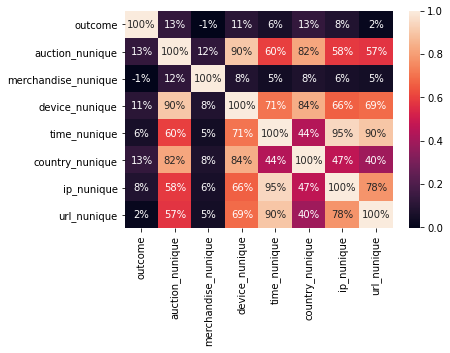

In [16]:
import seaborn as sns

sns.heatmap(train_set.corr(),annot=True , fmt='.0%')

